# TERCER NOTEBOOK - COSINE SIMILARITY MATRIX Y TOPIC MODELING LDA (STEMMING) - OBSERVACIONES 

**Contenido**:

1. Diseño del Algoritmo (Importar Paquetes y Funciones)
2. Cosine Similarity Matrix
3. Modelos LDA (Stemming)
    - Evaluación modelos LDA ( Mallet | Gensim | Sklearn )
    - Resultados del mejor modelo LDA  
    - Extracción de información

## I. DISEÑO DEL ALGORITMO

#### Importar paquetes

In [1]:
import re, pickle, datetime, spacy, numpy as np, pandas as pd
from pprint import pprint
from wordcloud import WordCloud
import matplotlib.colors as mcolors
from collections import Counter

# Gensim
import gensim, gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.matutils import softcossim 
import gensim.downloader as api

# Plotting tools
import pyLDAvis, pyLDAvis.sklearn, pyLDAvis.gensim  
import matplotlib.pyplot as plt

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim

# Download the FastText model
fasttext_model300 = api.load('fasttext-wiki-news-subwords-300')

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.simplefilter('ignore')
pd.options.mode.chained_assignment = None  # default='warn' ---> Not showing warnings about iloc

# Stop Words
with open('../spanish4.0.txt','r') as f:
    stop_words = f.read().splitlines()
    
# NLP from Spacy
nlp = spacy.load('es_core_news_md', disable=['parser', 'ner'])

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {return false;}

<IPython.core.display.Javascript object>

#### Estructura del Algoritmo 

In [3]:
# COSINE SIMILARITY MATRIX
def create_soft_cossim_matrix(sentences):
    len_array = np.arange(len(sentences))
    xx, yy = np.meshgrid(len_array, len_array)
    cossim_mat = pd.DataFrame([[round(softcossim(sentences[i],sentences[j], similarity_matrix) ,2) for i, j in zip(x,y)] for y, x in zip(xx, yy)])
    return cossim_mat

In [4]:
# TOPIC MODELING (LDA)
def coherence_values_mallet(dictionary, corpus, texts, start=2, limit=31, step=2):
    coherence_values = []
    model_list = []
    mallet_path = 'C:/Users/alexa/mallet-2.0.8/bin/mallet.bat' 
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, 
                                                 corpus=corpus, 
                                                 num_topics=num_topics, 
                                                 id2word=dictionary, 
                                                 random_seed = 1996)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values
def coherence_values_gensim(dictionary, corpus, texts, start=2, limit=31, step=2):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=dictionary, 
                                                num_topics=num_topics, 
                                                random_state=1996, 
                                                update_every=1, 
                                                chunksize=100, 
                                                passes=10, 
                                                alpha='auto', 
                                                per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

def coherence_values_sklearn(data_lemmatized, start=2, limit=31, step=2):
    data_lemmatized2 = [' '.join(sent) for sent in data_lemmatized]
    cv = CountVectorizer(stop_words = stop_words,max_df=0.95, min_df=2)
    data_cv = cv.fit_transform(data_lemmatized2) # document term-matrix (dtm)
    coherence_values = []
    model_list = [] 
    for num_topics in range(start, limit, step):
        model = LatentDirichletAllocation(n_components=num_topics,          
                                          max_iter=10,               
                                          learning_method='online',   
                                          random_state=1996,           
                                          batch_size=128,            
                                          n_jobs = -1)
        model.fit(data_cv)
        model_list.append(model)
        coherencemodel = metric_coherence_gensim(measure='c_v', 
                                                 top_n=20, 
                                                 topic_word_distrib=model.components_, 
                                                 dtm=data_cv, 
                                                 vocab= np.array([x for x in cv.vocabulary_.keys()]),
                                                 texts = data_lemmatized)
        coherencemodel = np.array(coherencemodel)
        coherence_values.append(np.mean(coherencemodel))
    return model_list, coherence_values , cv

def plot_coherence(cv1,cv2,cv3, start=2,limit=31,step=2, save=False, figsize = (12,6)):
    x = range(start, limit, step) 
    plt.rcParams.update({'figure.figsize':figsize})
    plt.plot(x, cv1 , label = 'LDA Mallet')
    plt.plot(x, cv2 , label = 'LDA Gensim')
    plt.plot(x, cv3 , label = 'LDA Sklearn')
    plt.title('LDA Coherence')
    plt.xlabel("Topics")
    plt.ylabel("Coherence score")
    plt.legend()
    plt.grid(color='gray', linestyle='-', linewidth=1, alpha = 0.1)
    if save:
        plt.savefig('plot coherence.jpg', dpi= 200, quality=95)
    plt.show()

def coherence_summary(cv_mallet, cv_gensim, cv_sklearn, start=2,limit=31,step=2):
    num_topics = list(range(start,limit,step))
    d = {'Nro Tópicos': num_topics , 'LDA Mallet': cv_mallet, 'LDA Gensim': cv_gensim, 'LDA Sklearn': cv_sklearn}
    return pd.DataFrame(d)
    
def top15words_sklearn(lda_model, cv):
    for index,topic in enumerate(lda_model.components_):
        print(f'TOPIC {index}')
        words = [cv.get_feature_names()[i] for i in topic.argsort()[-15:]]
        print(words[::-1])
        print('\n')

In [5]:
# VISUALIZACIÓN
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

def plot_freqdist(doc_lens, bins = None, xtick=300, width_text = 0.8, height_text = 0.65, save = False, figsize = (10,7)):
    import seaborn as sns
    mean = round(np.mean(doc_lens))
    median = round(np.median(doc_lens))
    stdev = round(np.std(doc_lens))
    oneperc = round(np.quantile(doc_lens, q=0.01))
    nnineperc = round(np.quantile(doc_lens, q=0.99))
    
    plt.figure(figsize=figsize)
    plt.hist(doc_lens, bins = bins, color='royalblue')
    plt.text(width_text, height_text, f'Mean: {mean} \n\nMedian: {median} \n\nStdev: {stdev} \n\n1%ile: {oneperc} \n\n99%ile: {nnineperc}', transform=plt.gca().transAxes)
    plt.gca().set(ylabel='Número de documentos', xlabel='Cantidad de palabras')
    plt.title('Distribución de la cantidad de palabras por documento')
    sns.kdeplot(doc_lens, color="gray", shade=False, ax=plt.gca().twinx())
    #plt.tick_params(size=16)
    plt.xticks(np.linspace(0,xtick,11))
    plt.xlim(0,xtick)
    if save:
        plt.savefig('freq dist total.jpg', dpi= 200, quality=95)
    plt.show()
    
def plot_freqdist_topic(doc_lens, bins = None,rows = 8, cols = 2, width_text = 0.76, height_text = 0.68, figsize= (15,40), save = False):
    import seaborn as sns
    fig, axes = plt.subplots(rows,cols,figsize=figsize, sharex=True, sharey=True)
    
    for i, ax in enumerate(axes.flatten()):    
        df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
        doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
        
        mean = round(np.mean(doc_lens))
        median = round(np.median(doc_lens))
        stdev = round(np.std(doc_lens))
        
        ax.hist(doc_lens, bins= bins, color=colors[i])
        ax.tick_params(axis='y', labelcolor=colors[i], color=colors[i])
        sns.kdeplot(doc_lens, color='gray', shade=False, ax=ax.twinx())
        ax.set(xlim=(0, 200), xlabel='Cantidad de palabras')
        ax.set_ylabel('Número de documentos', color=colors[i])
        ax.set_title('Tópico '+str(i), fontdict=dict(color=colors[i]))
        ax.set_xticks(np.linspace(0,200,11))
        plt.text(width_text, height_text, f'Mean: {mean} \n\nMedian: {median} \n\nStdev: {stdev}', transform=plt.gca().transAxes)
    fig.tight_layout(pad= 1.2)
    fig.subplots_adjust(top=0.90)
    #plt.xticks(np.linspace(0,200,11))
    if save:
        plt.savefig('freq dist total per topic.jpg', dpi= 200, quality=95)
    plt.show()
    
def word_cloud(lda_model,rows=4, cols=4, figsize = (14,16), save = False):
    # figsize = (width,height)
    cloud = WordCloud(stopwords=stop_words,background_color='white',width=2500,height=1800,max_words=15,colormap='tab10',color_func=lambda *args, **kwargs: colors[i],prefer_horizontal=1.0)
    topics = lda_model.show_topics(formatted=False,num_topics=100,num_words=15)
    fig, axes = plt.subplots(rows, cols, figsize=figsize, sharex=True, sharey=True)

        
    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Tópico ' + str(i), fontdict=dict(size=12), fontweight='bold')
        plt.gca().axis('off')
        
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout(pad=2)
    if save:
        plt.savefig('word cloud.jpg', dpi= 200, quality=95)
    plt.show()

colors = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#42d4f4', '#f032e6', '#bfef45', '#fabed4', '#469990', '#dcbeff', '#9A6324', '#ffe119', '#800000', '#3cb44b', '#808000', '#f58231', '#000075', '#a9a9a9', '#000000','#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#42d4f4', '#f032e6', '#bfef45', '#fabed4', '#469990', '#dcbeff', '#9A6324', '#ffe119', '#800000', '#3cb44b', '#808000', '#f58231', '#000075', '#a9a9a9', '#000000']    

In [6]:
# EVOLUCIÓN DEL TÓPICO EN EL TIEMPO
def topic_timeline(name, namecol,topic_nro, df_topic, figsize = (12,6), save = False):
    
    if name!=None and namecol!=None:
        df_topic = df_topic[df_topic[namecol] == name]
    df = df_topic[df_topic['Topico Dominante'] == topic_nro]
    c = colors[topic_nro]
    
    plt.figure(1)
    
    if name!=None and namecol!=None:
        plt.suptitle(f"Timeline - Tópico {topic_nro} en {namecol} {name}",  fontweight="bold", fontdict={'fontsize':10})
    else:
        plt.suptitle(f"Timeline - Tópico {topic_nro}",  fontweight="bold", fontdict={'fontsize':10})
        
    plt.rcParams.update({'figure.figsize':figsize})
    #print((f"\033[1mCantidad de meses: {len(sorted(df['Mes'].unique()))}\033[0m")) # Nro de meses
    meses = Counter(df["Mes"]) # Cantidad de mantenciones por mes
    #print(meses)
    plt.subplot(321)
    mi = ['JUL 18','AGO 18','SEP 18','OCT 18','NOV 18','DIC 18','ENE 19','FEB 19','MAR 19','ABR 19','MAY 19','JUN 19','JUL 19', 'AGO 19']
    mv = [meses[i] for i in mi]
    plt.plot(mi, mv, color = c, marker = 'o')
    plt.title(f"Cantidad de OT por mes en tópico {topic_nro}", fontweight= 'bold', fontsize = 10)
    plt.ylabel('Número de OT')
    plt.xticks(rotation=30)
    #plt.ylim(1200,2000)
    #plt.savefig('7.1) Mes.jpg', dpi= 200, quality=95)
    #plt.show()

    # -----------------------------------------------------------
    plt.subplot(322)
    #print((f"\033[1mCantidad de días: {len(sorted(df['Dia'].unique()))}\033[0m")) # Nro de dias
    n_dias = Counter(df['Nro Dia']) # Cantidad de mantenciones por número de dias
    #print(n_dias)
    d4 = n_dias.most_common(31)
    ni = [i for i,v in d4][::-1]
    nv = [v for i,v in d4][::-1]
    #plt.rcParams['figure.figsize'] = figsize
    plt.bar(ni, nv, align='center', color = c)
    plt.title(f"Cantidad de OT por día en tópico {topic_nro}",fontweight= 'bold', fontsize = 10)
    plt.ylabel('Número de OT')
    plt.xlabel('Dias')
    plt.xticks(range(1,32))
    #plt.savefig('7.2) Dia_nro.jpg', dpi= 200, quality=95)
    #plt.show()

    # -----------------------------------------------------------
    plt.subplot(323)
    dias = Counter(df["Dia"]) # Cantidad de mantenciones por dia
    #print(dias)
    di = ['Lunes','Martes','Miércoles','Jueves','Viernes','Sábado','Domingo']
    dv = [dias[i] for i in di]
    #plt.rcParams['figure.figsize'] = figsize
    plt.plot(di, dv, color = c, marker = 'o')
    plt.title(f"Cantidad de OT por día semanal en tópico {topic_nro}",fontweight= 'bold', fontsize = 10)
    plt.ylabel('Número de OT')
    plt.xticks(rotation=0)
    #plt.savefig('7.3) Dia_semana.jpg', dpi= 200, quality=95)
    #plt.show()

    # -----------------------------------------------------------
    plt.subplot(324)
    #print((f"\033[1mCantidad de horas en Recepción OT: {len(sorted(df['Hora'].unique()))}\033[0m")) # Nro de horas
    horas = Counter(df["Hora"]) # Cantidad de mantenciones por rango de hora
    #print(horas)
    d3 = horas.most_common(30)
    hi = [i for i,v in d3][::-1]
    hv = [v for i,v in d3][::-1]
    #plt.rcParams['figure.figsize'] = figsize
    plt.bar(hi, hv, align='center', color = c)
    plt.title(f"Cantidad de OT por hora en tópico {topic_nro}",fontweight= 'bold', fontsize = 10)
    plt.xlabel('Horas')
    plt.ylabel('Número de OT')
    plt.xticks(range(0,24))
    #plt.savefig('7.4) Hora.jpg', dpi= 200, quality=95)
    #plt.show()

    # -----------------------------------------------------------
    plt.subplot(325)
    #print((f"\033[1mDiferencia de tiempo entre la Recepción OT y el Arribo de Técnico: {len(sorted(df['Rango Recep/Arribo'].unique()))}\033[0m")) # Rango recep/arribo
    recep_arribo = Counter(df['Rango Recep/Arribo'])
    #print(recep_arribo)

    rango_di = ['0 a 24 horas', '1 a 2 días', '2 a 3 días','3 a 4 días','4 a 5 días','5 a 6 días','6 a 7 días', '1 a 2 semanas',
               '2 a 3 semanas','3 a 4 semanas','Más de 1 mes','Error en fechas']
    rango_dv = [recep_arribo[i] for i in rango_di]

    #plt.rcParams['figure.figsize'] = figsize
    plt.plot(rango_di, rango_dv, color = c, marker = 'o')
    plt.title(f"Tiempo entre recepción OT y arribo de técnico en tópico {topic_nro}",fontweight= 'bold', fontsize = 10)
    plt.ylabel('Número de OT')
    plt.xticks(rotation=50)
    #plt.savefig('7.5) Recepción OT y arribo de técnico asignado.jpg', dpi= 200, quality=95)
    #plt.show()
    
    # -----------------------------------------------------------
    plt.subplot(326)
    #print((f"\033[1mDiferencia de tiempo entre el Arribo y Cierre de trabajo: {len(sorted(df['Rango Arribo/Cierre'].unique()))}\033[0m")) # Rango arribo/cierre
    arribo_cierre = Counter(df['Rango Arribo/Cierre'])
    #print(arribo_cierre)

    rango_hi = ['Menos de 1h', '1 a 2 horas','2 a 3 horas','3 a 4 horas','4 a 5 horas','5 a 6 horas','6 a 7 horas',
              '7 a 8 horas','8 a 24 horas','1 a 3 días','3 a 7 días','1 a 4 semanas','Más de 1 mes','Error en horas']
    rango_hv = [arribo_cierre[i] for i in rango_hi]

    #plt.rcParams['figure.figsize'] = figsize
    plt.bar(rango_hi, rango_hv, color = c, align='center', width = 0.6)
    plt.title(f"Tiempo entre arribo y cierre de trabajo en tópico {topic_nro}",fontweight= 'bold', fontsize = 10)
    plt.ylabel('Número de OT')
    plt.xticks(rotation=50)
    #plt.savefig('7.6) Tiempo entre arribo  y cierre de trabajo.jpg', dpi= 200, quality=95)
    plt.tight_layout()
    plt.subplots_adjust(top=0.94)
    
    if name!=None and namecol!=None:
        if save: 
            plt.savefig(f'Timeline - Topic {topic_nro} en {namecol} {name}.jpg', dpi= 200, quality=95)
    else: 
        if save: 
            plt.savefig(f'Timeline - Topic {topic_nro}.jpg', dpi= 200, quality=95)
    plt.show()
    
# DISTRIBUCIÓN 6 PRINCIPALES TÓPICOS DE UNA COLUMNA EN TOP 9 (PIE)
def topics_top9(namecol, df, figsize = (18,14), save = False, angle = 100):
    plt.rcParams.update({'figure.figsize':figsize})
    colors2 = ['gold', 'yellowgreen', 'lightskyblue','royalblue','coral','turquoise']
    explode = (0, 0, 0, 0, 0, 0.1)  # explode 1st slice
    
    estacion_total= Counter(df[namecol])
    d = estacion_total.most_common(9)
    keys_est_total = [i for i,v in d][::-1]
    values_est_total = [v for i,v in d][::-1]
    
    for index, est in enumerate(keys_est_total[::-1]):
        df_est = df[df[namecol] == est]
        tfalla_total = Counter(df_est["Topico Dominante"])
        dic_tfallatotal = tfalla_total.most_common(6)

        keys = [f'Tópico {i}' for i,v in dic_tfallatotal][::-1]
        values = [v for i,v in dic_tfallatotal][::-1]
        plt.subplot(3,3,index+1)
        plt.pie(values,explode = explode, labels = keys, colors = colors2,autopct='%1.1f%%', shadow=True, startangle=angle)
        plt.axis('equal')
        plt.title((f'{index+1}) {est}'), fontweight="bold", fontdict={'fontsize':10})
    if save:
        plt.savefig(f'{namecol} top 9.jpg', dpi= 200, quality=95)
    plt.show()
    
# DISTRIBUCIÓN 6 PRINCIPALES TÓPICOS EN UNA COLUMNA DE UNA ENTIDAD CUALQUIERA (PIE)
def topics_top1(name, namecol, df, angle=100,figsize = (18,14), save = False):
    plt.rcParams.update({'figure.figsize':figsize})
    colors2 = ['gold', 'yellowgreen', 'lightskyblue','royalblue','coral','turquoise']
    explode = (0, 0, 0, 0, 0, 0.1)  # explode 1st slice

    df_est = df[df[namecol] == name]
    tfalla_total = Counter(df_est["Topico Dominante"])
    dic_tfallatotal = tfalla_total.most_common(6)

    keys = [f'Tópico {i}' for i,v in dic_tfallatotal][::-1]
    values = [v for i,v in dic_tfallatotal][::-1]
    plt.pie(values,explode = explode, labels = keys, colors = colors2,autopct='%1.1f%%', shadow=True, startangle=angle)
    plt.axis('equal')
    plt.title((f'{name}'), fontweight="bold", fontdict={'fontsize':12})
    if save:
        plt.savefig(f'{name} - {namecol}.jpg', dpi= 200, quality=95)
    plt.show()
    
# DISTRIBUCION DE TOPICOS TOTAL (BAR)
def topic_distribution(name, namecol, df_topic,s=111, vplus = 12, fontsize= 10, figsize= (12,10), save = False):
    if name!=None and namecol!=None:
        df_topic = df_topic[df_topic[namecol] == name]
    topicos = Counter(df_topic['Topico Dominante']) 
    ti = list(f'Tópico {i}'for i in range(0,len(topicos)))
    tv = [topicos[i] for i in range(0,len(topicos))]

    ax = plt.subplot(s)
    plt.rcParams.update({'figure.figsize':figsize})
    barlist = ax.barh(ti, tv, align='center', height = 0.5)

    for i, v in enumerate(tv):
        ax.text(v+vplus , i , str(v), color='black', va='center')
    for i in range(0,len(topicos)):
        barlist[i].set_color(colors[i])

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([])
    if name!=None and namecol!=None:
        plt.title(f"Distribución de OT por tópico en {namecol} {name}",  fontweight="bold", fontdict={'fontsize':fontsize})
        if save: 
            plt.savefig(f'Topic distribution barplot {name} - {namecol}.jpg', dpi= 200, quality=95)
    else: 
        plt.title("Distribución de OT por tópico",  fontweight="bold", fontdict={'fontsize':fontsize})
        if save: 
            plt.savefig('Topic distribution - barplot.jpg', dpi= 200, quality=95)
    plt.show()

# DISTRIBUCIÓN DE 2 ATRIBUTOS AL INTERIOR DE CUALQUIER TÓPICO (POR DEFECTO ESTACION Y TECNICO ASIGNADO)    
def topic_col1_col2 (topic_nro, namecol1, namecol2, df, angle=100,figsize = (12,7), save = False):
    plt.rcParams.update({'figure.figsize':figsize})
    colors2 = ['gold', 'yellowgreen', 'lightskyblue','royalblue','coral','turquoise']
    explode = (0, 0, 0, 0, 0, 0.1)  # explode 1st slice 
    df_est = df[df['Topico Dominante'] == topic_nro]
    
    plt.figure(1)
    plt.suptitle(f"Tópico {topic_nro}",  fontweight="bold", fontdict={'fontsize':14})
    
    plt.subplot(121)
    tfalla_total = Counter(df_est[namecol1])
    dic_tfallatotal = tfalla_total.most_common(6)
    keys = [i for i,v in dic_tfallatotal][::-1]
    values = [v for i,v in dic_tfallatotal][::-1]
    plt.pie(values,explode = explode, labels = keys, colors = colors2,autopct='%1.1f%%', shadow=True, startangle=angle)
    plt.axis('equal')
    plt.title((f'Top 6 {namecol1}'), fontweight="bold", fontdict={'fontsize':11})

    plt.subplot(122)
    tfalla_total2 = Counter(df_est[namecol2])
    dic_tfallatotal2 = tfalla_total2.most_common(6)
    keys2 = [i for i,v in dic_tfallatotal2][::-1]
    values2 = [v for i,v in dic_tfallatotal2][::-1]
    plt.pie(values2,explode = explode, labels = keys2, colors = colors2,autopct='%1.1f%%', shadow=True, startangle=angle)
    plt.axis('equal')
    plt.title((f'Top 6 {namecol2}'), fontweight="bold", fontdict={'fontsize':11})
    
    if save:
        plt.savefig(f'Top {namecol1} y {namecol2}-Tópico {topic_nro}.jpg', dpi= 200, quality=95)
    plt.show()

# DISTRIBUCIÓN DE 1 ATRIBUTO AL INTERIOR DE CUALQUIER TÓPICO 
def topic_namecol1(topic_nro, namecol, df, angle=100,figsize = (12,7), save = False, fontsize=12):
    plt.rcParams.update({'figure.figsize':figsize})
    colors2 = ['gold', 'yellowgreen', 'lightskyblue','royalblue','coral','turquoise']
    explode = (0, 0, 0, 0, 0, 0.1)  # explode 1st slice
    df_est = df[df['Topico Dominante'] == topic_nro]
    tfalla_total = Counter(df_est[namecol])
    dic_tfallatotal = tfalla_total.most_common(6)

    keys = [i for i,v in dic_tfallatotal][::-1]
    values = [v for i,v in dic_tfallatotal][::-1]

    plt.pie(values,explode = explode, labels = keys, colors = colors2,autopct='%1.1f%%', shadow=True, startangle=angle)
    plt.axis('equal')
    plt.title((f'Top 6 {namecol} en Tópico {topic_nro}'), fontweight="bold", fontdict={'fontsize':fontsize})
    if save:
        plt.savefig(f'Top 6 {namecol}-Tópico {topic_nro}.jpg', dpi= 200, quality=95)
    plt.show()
    
# KEYWORDS (TEXT)
def keywords_text(topic_nro, df):
    df = df[df['Topic_Num'] == topic_nro]
    print(f'\033[1mTop 10 palabras en Tópico {topic_nro}\033[0m')
    print([i for i in df['Keywords']])
    print(f'\n\033[1mTexto representativo en Tópico {topic_nro}\033[0m')
    print([i for i in df['Representative Text']])

#### Importar Data Frame

In [7]:
pd.options.display.max_colwidth = 10
df_topics = pd.read_pickle('BD_original_cleaned_TOPICO_DOMINANTE.pkl')
df_topics.head()

,Region,Estacion,Tipo de Falla,Prioridad Cliente,Estado OT,Tecnico Asignado,Dia,Nro Dia,Mes,Hora,Rango Recep/Arribo,Rango Arribo/Cierre,Observación,Requerimiento,Topico Dominante
0,13°,Tingar...,Carret...,Normal...,CERRADA,Juan A...,Viernes,30,AGO 19,16,Error ...,Más de...,se cam...,area d...,2
1,8°,Combus...,Carret...,Normal...,CERRADA,On Line,Viernes,30,AGO 19,12,Error ...,Menos ...,cambio...,area d...,23
2,10°,LLANOS...,Carret...,Normal...,PRECIERRE,Luis A...,Viernes,30,AGO 19,12,0 a 24...,Menos ...,se vis...,area d...,3
3,1°,Soc. I...,Carret...,Normal...,CERRADA,On Line,Viernes,30,AGO 19,12,0 a 24...,Menos ...,rempla...,area d...,4
4,3°,Inmobi...,Carret...,Normal...,CERRADA,On Line,Viernes,30,AGO 19,12,Error ...,Menos ...,rempla...,area d...,4


In [8]:
# Valores Únicos
for col in df_topics.columns:
    print(f"{col:20} {len(df_topics[col].unique()):10}")

Region                       15
Estacion                    999
Tipo de Falla                63
Prioridad Cliente            14
Estado OT                     4
Tecnico Asignado             79
Dia                           7
Nro Dia                      31
Mes                          14
Hora                         19
Rango Recep/Arribo           12
Rango Arribo/Cierre          14
Observación               18208
Requerimiento             15880
Topico Dominante             24


In [9]:
# Valores Nulos
df_topics.isnull().sum()

Region                 0
Estacion               0
Tipo de Falla          0
Prioridad Cliente      0
Estado OT              0
Tecnico Asignado       0
Dia                    0
Nro Dia                0
Mes                    0
Hora                   0
Rango Recep/Arribo     0
Rango Arribo/Cierre    0
Observación            0
Requerimiento          0
Topico Dominante       0
dtype: int64

Cantidad de Tópicos: 24
Counter({4: 2145, 15: 1535, 21: 1422, 23: 1398, 22: 1170, 16: 1141, 13: 1122, 7: 1014, 2: 1006, 3: 952, 1: 942, 0: 891, 11: 823, 14: 797, 12: 797, 8: 646, 17: 628, 9: 615, 5: 581, 18: 559, 10: 549, 6: 483, 20: 345, 19: 279})


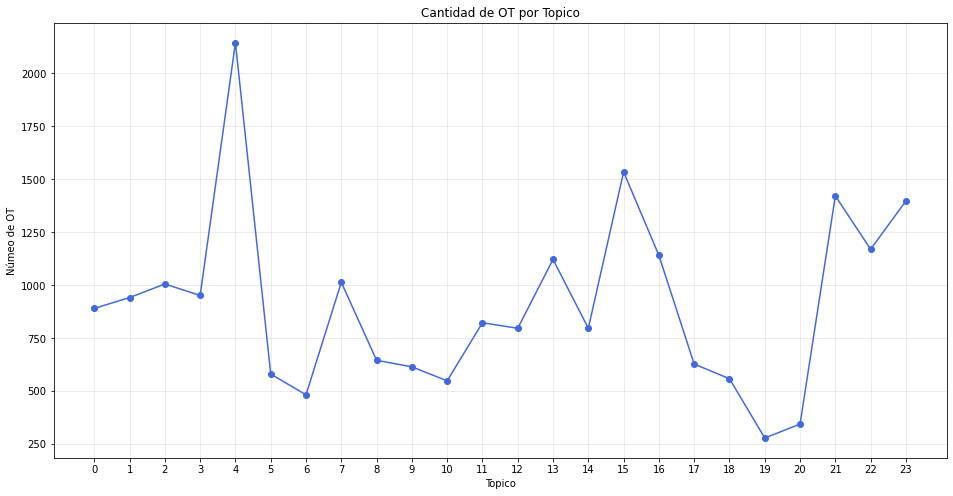

In [10]:
# Cantidad de OT por Tópico
print((f"\033[1mCantidad de Tópicos: {len(sorted(df_topics['Topico Dominante'].unique()))}\033[0m"))
tdominante_total = Counter(df_topics['Topico Dominante']) 
print(tdominante_total)
keys_tdominante_total = [i for i in range(0,24)]
x = list(range(0,24,1))
y = [tdominante_total[i] for i in keys_tdominante_total]

plt.rcParams['figure.figsize'] = [16,8]
#plt.bar(x, values_regtotal, align='center', color = "royalblue", width = 0.6)
plt.plot(x,y,color = "royalblue", marker = 'o')
plt.title("Cantidad de OT por Topico")
plt.xlabel("Topico")
plt.ylabel("Númeo de OT")
plt.xticks(list(range(0,24,1)))
plt.grid(axis='y', alpha = 0.3)
plt.grid(axis='x', alpha = 0.3)
#plt.savefig('1) Region_line2.jpg', dpi= 200, quality=95)
plt.show()

## II. COSINE SIMILARITY MATRIX

### COSINE SIMILARITY MATRIX (WITHOUT PRE-PROCESING)

In [12]:
d_topics = {}
for k in range(0,24,1):
    dataframe_topics = df_topics[df_topics['Topico Dominante']==k]
    d_topics[f'Topico {k}'] = [i for i in  dataframe_topics['Observación']]

In [13]:
d_topics.keys()

dict_keys(['Topico 0', 'Topico 1', 'Topico 2', 'Topico 3', 'Topico 4', 'Topico 5', 'Topico 6', 'Topico 7', 'Topico 8', 'Topico 9', 'Topico 10', 'Topico 11', 'Topico 12', 'Topico 13', 'Topico 14', 'Topico 15', 'Topico 16', 'Topico 17', 'Topico 18', 'Topico 19', 'Topico 20', 'Topico 21', 'Topico 22', 'Topico 23'])

In [14]:
%%time
# Prepare a dictionary and a corpus.
dictionary = corpora.Dictionary([simple_preprocess(doc) for i in range(0,24,1) for doc in d_topics[f'Topico {i}']])
# Prepare the similarity matrix
similarity_matrix = fasttext_model300.similarity_matrix(dictionary, tfidf=None, threshold=0.0, exponent=2.0, nonzero_limit=100)

Wall time: 5min 3s


In [15]:
sentences_x_topic = [' '.join(d_topics[f'Topico {i}']) for i in range(0,24,1)]
sentences = [dictionary.doc2bow(simple_preprocess(i)) for i in sentences_x_topic]
len(sentences)

24

In [16]:
# Get the Matrix
from IPython.display import display
pd.options.display.max_columns = None
display(create_soft_cossim_matrix(sentences))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,1.00,0.94,0.97,0.95,0.92,0.92,0.90,0.94,0.94,0.88,0.94,0.87,0.92,0.86,0.96,0.88,0.91,0.97,0.92,0.91,0.93,0.70,0.89,0.81
1,0.94,1.00,0.92,0.90,0.90,0.87,0.86,0.89,0.95,0.80,0.95,0.91,0.88,0.84,0.92,0.88,0.87,0.92,0.93,0.93,0.88,0.68,0.87,0.77
2,0.97,0.92,1.00,0.96,0.91,0.94,0.91,0.95,0.93,0.89,0.92,0.85,0.93,0.86,0.96,0.88,0.93,0.97,0.90,0.88,0.93,0.70,0.89,0.82
3,0.95,0.90,0.96,1.00,0.90,0.92,0.92,0.94,0.90,0.89,0.90,0.83,0.92,0.84,0.94,0.87,0.91,0.95,0.89,0.86,0.92,0.66,0.88,0.81
4,0.92,0.90,0.91,0.90,1.00,0.86,0.83,0.87,0.90,0.81,0.87,0.83,0.87,0.80,0.90,0.84,0.86,0.92,0.87,0.86,0.86,0.69,0.84,0.76
5,0.92,0.87,0.94,0.92,0.86,1.00,0.91,0.91,0.88,0.86,0.88,0.82,0.90,0.82,0.94,0.85,0.91,0.93,0.85,0.84,0.90,0.65,0.87,0.80
6,0.90,0.86,0.91,0.92,0.83,0.91,1.00,0.90,0.85,0.83,0.87,0.81,0.88,0.81,0.91,0.85,0.87,0.90,0.85,0.82,0.89,0.62,0.87,0.80
7,0.94,0.89,0.95,0.94,0.87,0.91,0.90,1.00,0.89,0.87,0.89,0.82,0.91,0.83,0.93,0.87,0.91,0.93,0.86,0.85,0.91,0.69,0.89,0.82
8,0.94,0.95,0.93,0.90,0.90,0.88,0.85,0.89,1.00,0.80,0.95,0.90,0.91,0.85,0.94,0.89,0.89,0.92,0.95,0.94,0.89,0.70,0.90,0.77
9,0.88,0.80,0.89,0.89,0.81,0.86,0.83,0.87,0.80,1.00,0.78,0.71,0.84,0.78,0.87,0.80,0.83,0.89,0.78,0.71,0.88,0.58,0.77,0.83


### COSINE SIMILARITY MATRIX (WITH LEMMATIZATION)

In [17]:
def texts_only(sentence, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV','PROPN']):
    # Tokenization
    texts = [gensim.utils.simple_preprocess(str(sentence), deacc=True)]
    # Remove stopwords
    texts = [word for word in texts if word not in stop_words]
    # lemmatization
    texts_out = []
    for word in texts:
        doc = nlp(u" ".join(word))
        for token in doc:
            if token.pos_ in allowed_postags:
                 texts_out.append(token.lemma_)
    # Remove stopwords once more after lemmatization
    texts_out = [word for word in texts_out if word not in stop_words]
    texts_out = ' '.join(texts_out)
    return texts_out

In [19]:
# Apply Lemmatization function (texts_only) to the DF
df_topics_lemmatization = df_topics.copy()
pd.options.display.max_colwidth = 12
df_topics_lemmatization['Observación'] = df_topics_lemmatization['Observación'].apply(texts_only)
df_topics_lemmatization.head()

,Region,Estacion,Tipo de Falla,Prioridad Cliente,Estado OT,Tecnico Asignado,Dia,Nro Dia,Mes,Hora,Rango Recep/Arribo,Rango Arribo/Cierre,Observación,Requerimiento,Topico Dominante
0,13°,Tingaro ...,Carrete ...,Normal 4...,CERRADA,Juan Aliaga,Viernes,30,AGO 19,16,Error en...,Más de 1...,cambiar ...,area de ...,2
1,8°,Combusti...,Carrete ...,Normal (...,CERRADA,On Line,Viernes,30,AGO 19,12,Error en...,Menos de 1h,cambiar ...,area de ...,23
2,10°,LLANOS Y...,Carrete ...,Normal 2...,PRECIERRE,Luis Alm...,Viernes,30,AGO 19,12,0 a 24 h...,Menos de 1h,visitar ...,area de ...,3
3,1°,Soc. Imp...,Carrete ...,Normal (...,CERRADA,On Line,Viernes,30,AGO 19,12,0 a 24 h...,Menos de 1h,remplaza...,area de ...,4
4,3°,Inmobili...,Carrete ...,Normal (...,CERRADA,On Line,Viernes,30,AGO 19,12,Error en...,Menos de 1h,remplaza...,area de ...,4


In [20]:
# Normal
df_topics['Observación'][200]

'se cierra bajo os 105723 por tratarse de misma incidencia se cierra bajo os 105723 por tratarse de misma incidencia'

In [21]:
# Lemmatization
df_topics_lemmatization['Observación'][200]

'cerrar tratarse incidencia cerrar tratarse incidencia'

In [22]:
d_topics = {}
for k in range(0,24,1):
    dataframe_topics = df_topics_lemmatization[df_topics_lemmatization['Topico Dominante']==k]
    d_topics[f'Topico {k}'] = [i for i in  dataframe_topics['Observación']]

In [23]:
%%time
# Prepare a dictionary and a corpus.
dictionary = corpora.Dictionary([simple_preprocess(doc) for i in range(0,24,1) for doc in d_topics[f'Topico {i}']])
# Prepare the similarity matrix
similarity_matrix = fasttext_model300.similarity_matrix(dictionary, tfidf=None, threshold=0.0, exponent=2.0, nonzero_limit=100)

Wall time: 2min 4s


In [24]:
sentences_x_topic = [' '.join(d_topics[f'Topico {i}']) for i in range(0,24,1)]
sentences = [dictionary.doc2bow(simple_preprocess(i)) for i in sentences_x_topic]
len(sentences)

24

In [25]:
from IPython.display import display
pd.options.display.max_columns = None
display(create_soft_cossim_matrix(sentences))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,1.00,0.56,0.72,0.69,0.51,0.55,0.66,0.65,0.50,0.60,0.60,0.31,0.57,0.38,0.68,0.45,0.60,0.72,0.51,0.69,0.68,0.37,0.54,0.31
1,0.56,1.00,0.58,0.56,0.49,0.43,0.53,0.52,0.49,0.44,0.57,0.46,0.44,0.33,0.52,0.48,0.47,0.61,0.52,0.59,0.46,0.29,0.43,0.27
2,0.72,0.58,1.00,0.74,0.53,0.68,0.71,0.75,0.52,0.62,0.59,0.27,0.65,0.42,0.74,0.51,0.69,0.81,0.48,0.68,0.68,0.39,0.61,0.31
3,0.69,0.56,0.74,1.00,0.52,0.59,0.72,0.65,0.45,0.55,0.55,0.28,0.56,0.40,0.64,0.44,0.60,0.80,0.47,0.61,0.60,0.37,0.57,0.30
4,0.51,0.49,0.53,0.52,1.00,0.40,0.48,0.45,0.43,0.37,0.42,0.32,0.39,0.29,0.45,0.38,0.42,0.54,0.45,0.53,0.41,0.29,0.40,0.26
5,0.55,0.43,0.68,0.59,0.40,1.00,0.63,0.52,0.44,0.53,0.53,0.22,0.59,0.34,0.72,0.47,0.65,0.67,0.40,0.56,0.54,0.30,0.55,0.29
6,0.66,0.53,0.71,0.72,0.48,0.63,1.00,0.65,0.44,0.49,0.55,0.29,0.57,0.37,0.69,0.46,0.58,0.75,0.54,0.59,0.63,0.36,0.59,0.42
7,0.65,0.52,0.75,0.65,0.45,0.52,0.65,1.00,0.47,0.54,0.52,0.23,0.61,0.37,0.68,0.39,0.61,0.68,0.37,0.61,0.59,0.49,0.65,0.38
8,0.50,0.49,0.52,0.45,0.43,0.44,0.44,0.47,1.00,0.44,0.50,0.30,0.53,0.35,0.61,0.45,0.51,0.48,0.55,0.55,0.49,0.37,0.49,0.32
9,0.60,0.44,0.62,0.55,0.37,0.53,0.49,0.54,0.44,1.00,0.53,0.24,0.61,0.40,0.66,0.41,0.58,0.67,0.34,0.54,0.57,0.31,0.57,0.23


### COSINE SIMILARITY MATRIX (WITH STEMMING)

In [26]:
# Limpieza de palabras
def word_cleaner(sent):
    import string,re
    from unidecode import unidecode
    text = sent.lower() 
    text = re.sub('\d+-\d+-\d+','',text)    # Elimina fechas en formato DD-MM-YYYY y D-M-YY
    text = re.sub('\d+/\d+/\d+','',text)    # Elimina fechas en formato DD/MM/YYYY y D/M/YY
    text = re.sub('\d+:\d+', '', text)      # Elimina horas en formato HH:MM 
    text = re.sub('\S*@\S*\s?','',text)     # Elimina emails
    text = re.sub(r'\d{7,9}','', text)      # Elimina teléfonos 
    text = re.sub('\[.*?¿\]\%', '', text)   # Elimina .*?¿\
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)  # Elimina puntuación restante, como ¡! /
    text = re.sub('[%s]' % re.escape('°'), ' ', text)
    text = re.sub('[‘’“”…«»/]', '', text)
    text = unidecode(text)                  # Elimina tildes y acentos (ñ -> n)
    text = re.sub('\n', ' ', text)          # Elimina saltos de linea
    text = re.sub(r'\s{2,}', ' ', text)     # Elimina dos o más espacios en blancos seguidos
    text = re.sub(r"^\s+", "", text, flags=re.UNICODE)      # Elimina espacios blancos al principio
    text = re.sub("^\s+|\s+$", "", text, flags=re.UNICODE)  # Elimina espacios blancos al final
    text = re.sub('\w*\d\w*', '', text)    # Elimina digitos
    #text = re.sub(r'(.)\1+', r'\1', text)  # Elimina caracteres duplicados
    return text 

In [27]:
def texts_only_stem(sentence, stop_words=stop_words):
    import nltk
    from nltk import SnowballStemmer
    spanishstemmer=SnowballStemmer("spanish")
    sentence = word_cleaner(sentence)
    # Tokenization
    texts = [gensim.utils.simple_preprocess(str(sentence), deacc=True)]
    # Remove stopwords
    texts = [x for i in texts for x in i if x not in stop_words]
    # Stemming
    texts_out = [spanishstemmer.stem(token) for token in texts]
    texts_out = ' '.join(texts_out)
    return texts_out

In [28]:
# Apply Stemming function (texts_only_stem) to the DF
df_topics_stemming = df_topics.copy()
df_topics_stemming['Observación'] = df_topics_stemming['Observación'].apply(texts_only_stem)
df_topics_stemming.head()

,Region,Estacion,Tipo de Falla,Prioridad Cliente,Estado OT,Tecnico Asignado,Dia,Nro Dia,Mes,Hora,Rango Recep/Arribo,Rango Arribo/Cierre,Observación,Requerimiento,Topico Dominante
0,13°,Tingaro ...,Carrete ...,Normal 4...,CERRADA,Juan Aliaga,Viernes,30,AGO 19,16,Error en...,Más de 1...,cambi pl...,area de ...,2
1,8°,Combusti...,Carrete ...,Normal (...,CERRADA,On Line,Viernes,30,AGO 19,12,Error en...,Menos de 1h,cambi gr...,area de ...,23
2,10°,LLANOS Y...,Carrete ...,Normal 2...,PRECIERRE,Luis Alm...,Viernes,30,AGO 19,12,0 a 24 h...,Menos de 1h,eds cheq...,area de ...,3
3,1°,Soc. Imp...,Carrete ...,Normal (...,CERRADA,On Line,Viernes,30,AGO 19,12,0 a 24 h...,Menos de 1h,remplaz ...,area de ...,4
4,3°,Inmobili...,Carrete ...,Normal (...,CERRADA,On Line,Viernes,30,AGO 19,12,Error en...,Menos de 1h,remplaz ...,area de ...,4


In [29]:
# Normal
df_topics['Observación'][80]

'se realiza chequeo a equipo lados n5 y n6 se chequean preset los cuales estan operando de forma normal sin problemas equipo operativo trabajo realizado en presencia de encargado de estacion de servicio se realiza chequeo a equipo lados n5 y n6 se chequean preset los cuales estan operando de forma normal sin problemas equipo operativo trabajo realizado en presencia de encargado de estacion de servicio'

In [30]:
# Lemmatization
df_topics_lemmatization['Observación'][80]

'chequeo equipar lado preset estan operar formar normal equipar trabajar presenciar encargar servicio chequeo equipar lado preset estan operar formar normal equipar trabajar presenciar encargar servicio'

In [31]:
# Stemming
df_topics_stemming['Observación'][80]

'cheque equip lad chequ preset cual estan oper form normal problem equip trabaj realiz presenci encarg servici cheque equip lad chequ preset cual estan oper form normal problem equip trabaj realiz presenci encarg servici'

In [32]:
d_topics = {}
for k in range(0,24,1):
    dataframe_topics = df_topics_stemming[df_topics_stemming['Topico Dominante']==k]
    d_topics[f'Topico {k}'] = [i for i in  dataframe_topics['Observación']]

In [34]:
%%time
# Texts 
texts_stem = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in df_topics_stemming['Observación']]
# Dictionary
dictionary = corpora.Dictionary([simple_preprocess(doc) for i in range(0,24,1) for doc in d_topics[f'Topico {i}']])
# Corpus
corpus = [dictionary.doc2bow(text) for text in texts_stem]
# Prepare the similarity matrix
similarity_matrix = fasttext_model300.similarity_matrix(dictionary, tfidf=None, threshold=0.0, exponent=2.0, nonzero_limit=100)

Wall time: 3min 14s


In [35]:
sentences_x_topic = [' '.join(d_topics[f'Topico {i}']) for i in range(0,24,1)]
sentences = [dictionary.doc2bow(simple_preprocess(i)) for i in sentences_x_topic]
len(sentences)

24

In [36]:
from IPython.display import display
pd.options.display.max_columns = None
display(create_soft_cossim_matrix(sentences))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,1.00,0.34,0.60,0.58,0.36,0.45,0.55,0.52,0.37,0.52,0.52,0.22,0.45,0.24,0.53,0.36,0.47,0.62,0.44,0.54,0.55,0.32,0.41,0.30
1,0.34,1.00,0.34,0.32,0.28,0.29,0.32,0.30,0.40,0.25,0.49,0.43,0.25,0.16,0.29,0.35,0.27,0.38,0.42,0.47,0.27,0.20,0.24,0.23
2,0.60,0.34,1.00,0.62,0.36,0.61,0.60,0.62,0.38,0.58,0.50,0.17,0.55,0.29,0.59,0.39,0.57,0.73,0.40,0.50,0.54,0.35,0.49,0.31
3,0.58,0.32,0.62,1.00,0.34,0.53,0.65,0.54,0.32,0.54,0.47,0.18,0.50,0.28,0.52,0.34,0.53,0.71,0.39,0.46,0.50,0.32,0.49,0.27
4,0.36,0.28,0.36,0.34,1.00,0.30,0.33,0.31,0.32,0.28,0.31,0.18,0.29,0.17,0.31,0.35,0.31,0.38,0.34,0.35,0.29,0.22,0.30,0.27
5,0.45,0.29,0.61,0.53,0.30,1.00,0.62,0.40,0.35,0.47,0.48,0.18,0.52,0.24,0.61,0.40,0.56,0.63,0.42,0.44,0.42,0.27,0.48,0.30
6,0.55,0.32,0.60,0.65,0.33,0.62,1.00,0.54,0.33,0.51,0.51,0.25,0.50,0.25,0.61,0.39,0.49,0.68,0.51,0.44,0.53,0.33,0.53,0.43
7,0.52,0.30,0.62,0.54,0.31,0.40,0.54,1.00,0.34,0.41,0.40,0.13,0.47,0.23,0.50,0.35,0.46,0.59,0.33,0.47,0.42,0.43,0.54,0.43
8,0.37,0.40,0.38,0.32,0.32,0.35,0.33,0.34,1.00,0.32,0.46,0.33,0.42,0.24,0.52,0.39,0.39,0.37,0.54,0.48,0.37,0.32,0.38,0.30
9,0.52,0.25,0.58,0.54,0.28,0.47,0.51,0.41,0.32,1.00,0.48,0.16,0.55,0.27,0.53,0.37,0.48,0.65,0.32,0.41,0.46,0.28,0.45,0.24


## III. MODELOS LDA (STEMMING)

### EVALUACIÓN MODELOS (MALLET | GENSIM | SKLEARN)

In [273]:
%%time
# 1) LDA MALLET
# model_list1, coherence_values1 = coherence_values_mallet(dictionary=dictionary, corpus=corpus,texts=texts_stem,start=2,limit=31,step=2)

Wall time: 15min 32s


In [278]:
%%time
# 2) LDA GENSIM
# model_list2, coherence_values2 = coherence_values_gensim(dictionary=dictionary, corpus=corpus,texts=texts_stem,start=2,limit=31,step=2)

Wall time: 25min 22s


In [279]:
%%time
# 3) LDA SKLEARN
# model_list3, coherence_values3 , cv = coherence_values_sklearn(data_lemmatized=texts_stem,start=2,limit=31,step=2)

Wall time: 13min 12s


In [281]:
# SAVE MODELS AND COHERENCES
'''
with open('model_list1_stem.pkl', 'wb') as f:
    pickle.dump(model_list1, f)
with open('model_list2_stem.pkl', 'wb') as f:
    pickle.dump(model_list2, f)
with open('model_list3_stem.pkl', 'wb') as f:
    pickle.dump(model_list3, f)
with open('coherence_values1_stem.pkl', 'wb') as f:
    pickle.dump(coherence_values1, f)
with open('coherence_values2_stem.pkl', 'wb') as f:
    pickle.dump(coherence_values2, f)
with open('coherence_values3_stem.pkl', 'wb') as f:
    pickle.dump(coherence_values3, f)
with open('countvectorizer-sklearn_stem.pkl', 'wb') as f:
    pickle.dump(cv, f)
    
with open('texts_stem.pkl', 'wb') as f:
    pickle.dump(texts_stem, f)
with open('dictionary_stem.pkl', 'wb') as f:
    pickle.dump(dictionary, f)
with open('corpus_stem.pkl', 'wb') as f:
    pickle.dump(corpus, f)
'''

In [11]:
# READ PICKLED ELEMENTS FROM ABOVE
with open('model_list1_stem.pkl', 'rb') as f:
    model_list1 = pickle.load(f)
with open('model_list2_stem.pkl', 'rb') as f:
    model_list2 = pickle.load(f)
with open('model_list3_stem.pkl', 'rb') as f:
    model_list3 = pickle.load(f)
    
with open('coherence_values1_stem.pkl', 'rb') as f:
    coherence_values1 = pickle.load(f)
with open('coherence_values2_stem.pkl', 'rb') as f:
    coherence_values2 = pickle.load(f)
with open('coherence_values3_stem.pkl', 'rb') as f:
    coherence_values3 = pickle.load(f)

with open('countvectorizer-sklearn_stem.pkl', 'rb') as f:
    cv = pickle.load(f)
    
with open('texts_stem.pkl', 'rb') as f:
    texts_stem = pickle.load(f)
with open('dictionary_stem.pkl', 'rb') as f:
    dictionary = pickle.load(f)
with open('corpus_stem.pkl', 'rb') as f:
    corpus = pickle.load(f)

#### LDA Coherence

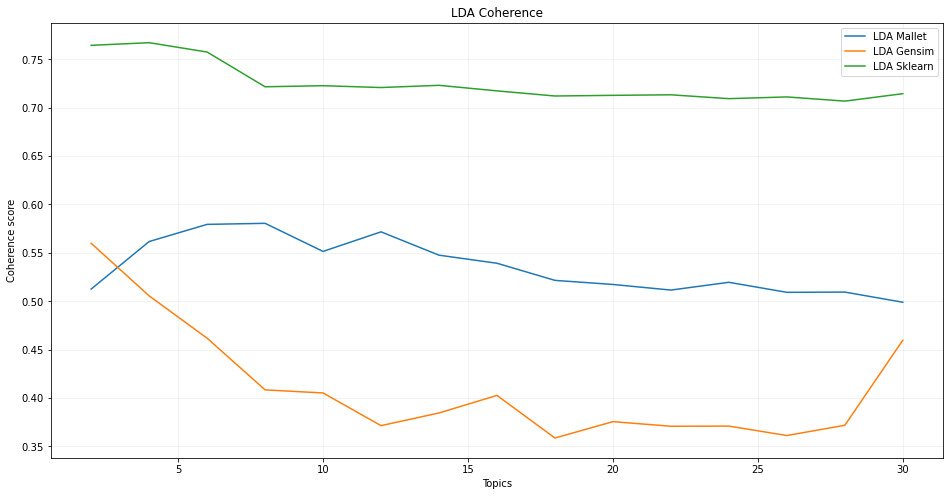

In [12]:
plot_coherence(cv1=coherence_values1,cv2=coherence_values2,cv3=coherence_values3,start=2,limit=31,step=2, figsize=(16,8))

In [13]:
# DF COHERENCES
c_summary = coherence_summary(cv_mallet=coherence_values1,cv_gensim=coherence_values2, cv_sklearn=coherence_values3,start=2,limit=31,step=2)
c_summary

,Nro Tópicos,LDA Mallet,LDA Gensim,LDA Sklearn
0,2,0.512605,0.559961,0.764464
1,4,0.561709,0.505585,0.767196
2,6,0.579451,0.461850,0.757543
3,8,0.580535,0.408445,0.721641
4,10,0.551514,0.405256,0.722742
5,12,0.571729,0.371478,0.720852
6,14,0.547627,0.384590,0.723144
7,16,0.539284,0.402727,0.717397
8,18,0.521589,0.358673,0.712112
9,20,0.517364,0.375613,0.712783


#### Top 15 words per topic - LDA MALLET

In [13]:
# TOP LDA MALLET
optimal_model1 = model_list1[11]
pprint(optimal_model1.print_topics(num_words=20, num_topics= 100))

[(0,
  '0.501*"dispens" + 0.278*"gas" + 0.060*"verif" + 0.022*"deb" + '
  '0.022*"efectu" + 0.010*"mantien" + 0.009*"continu" + 0.008*"ambos" + '
  '0.008*"verific" + 0.006*"igual" + 0.006*"volv" + 0.004*"breakaways" + '
  '0.004*"lleg" + 0.004*"intercambi" + 0.004*"inici" + 0.003*"manteni" + '
  '0.003*"expend" + 0.003*"mencion" + 0.003*"rotur" + 0.002*"cer"'),
 (1,
  '0.281*"surtidor" + 0.211*"despach" + 0.170*"normal" + 0.093*"isla" + '
  '0.041*"form" + 0.031*"corre" + 0.021*"ajust" + 0.020*"condicion" + '
  '0.019*"public" + 0.018*"posicion" + 0.008*"otcerr" + 0.008*"tambi" + '
  '0.005*"lueg" + 0.005*"islas" + 0.004*"igual" + 0.004*"brekaway" + '
  '0.004*"destorsedor" + 0.003*"pon" + 0.002*"bus" + 0.002*"tensor"'),
 (2,
  '0.071*"regl" + 0.068*"root" + 0.067*"veed" + 0.048*"tk" + 0.048*"sensor" + '
  '0.045*"medicion" + 0.033*"consol" + 0.032*"alarm" + 0.021*"sump" + '
  '0.021*"tod" + 0.017*"tabl" + 0.017*"kerosen" + 0.015*"funcion" + '
  '0.015*"nuev" + 0.014*"diferent" + 0.01

#### Top 15 words per topic - LDA GENSIM

In [14]:
# TOP LDA GENSIM
optimal_model2 = model_list2[3]
pprint(optimal_model2.print_topics(num_words=15, num_topics= 100))

[(0,
  '0.313*"dispens" + 0.107*"lad" + 0.051*"cambi" + 0.051*"plac" + 0.036*"fund" '
  '+ 0.035*"preset" + 0.027*"tecl" + 0.021*"enex" + 0.020*"conjunt" + '
  '0.019*"prueb" + 0.015*"control" + 0.011*"mal" + 0.011*"condicion" + '
  '0.011*"precort" + 0.010*"negr"'),
 (1,
  '0.117*"mal" + 0.063*"reemplaz" + 0.058*"repuest" + 0.054*"medidor" + '
  '0.053*"baj" + 0.052*"emit" + 0.045*"ot" + 0.042*"breakaway" + '
  '0.037*"incident" + 0.034*"pos" + 0.028*"extra" + 0.027*"atend" + '
  '0.027*"ods" + 0.018*"quebr" + 0.016*"vapor"'),
 (2,
  '0.101*"equip" + 0.091*"cambi" + 0.063*"product" + 0.055*"boc" + '
  '0.048*"filtr" + 0.047*"surtidor" + 0.045*"despach" + 0.044*"prueb" + '
  '0.033*"vent" + 0.031*"diesel" + 0.023*"normal" + 0.023*"fluj" + '
  '0.022*"isla" + 0.021*"oper" + 0.017*"filtracion"'),
 (3,
  '0.065*"agu" + 0.051*"tap" + 0.048*"estanqu" + 0.045*"retir" + 0.045*"tk" + '
  '0.034*"diesel" + 0.031*"litr" + 0.028*"uso" + 0.028*"calibracion" + '
  '0.025*"kerosen" + 0.024*"regl" + 

#### Top 15 words per topic - LDA SKLEARN

In [15]:
# TOP LDA SKLEARN
optimal_model3 = model_list3[11]
top15words_sklearn(lda_model=optimal_model3,cv = cv)

TOPIC 0
['boc', 'equip', 'mal', 'reemplaz', 'cambi', 'pos', 'filtracion', 'uso', 'diesel', 'oper', 'destorcedor', 'pendient', 'oring', 'reconect', 'gasolin']


TOPIC 1
['pistol', 'cambi', 'cort', 'fund', 'automat', 'pd', 'boc', 'can', 'pulg', 'negr', 'verd', 'ejecut', 'energi', 'instal', 'juni']


TOPIC 2
['plac', 'calibracion', 'program', 'mes', 'ajust', 'quebr', 'sol', 'rang', 'utiliz', 'encontr', 'senal', 'dispens', 'contact', 'conector', 'bien']


TOPIC 3
['prevent', 'mantencion', 'calibr', 'limpi', 'ampollet', 'calibracion', 'quem', 'cambi', 'manten', 'display', 'tdf', 'medicion', 'pls', 'contenedor', 'ker']


TOPIC 4
['equip', 'cheque', 'prueb', 'servici', 'client', 'oper', 'product', 'chequ', 'vent', 'recirculacion', 'form', 'normal', 'realiz', 'encarg', 'trabaj']


TOPIC 5
['tap', 'boc', 'limpiez', 'descarg', 'spill', 'volumetr', 'pint', 'verificacion', 'surtidor', 'estanqu', 'emergent', 'litr', 'par', 'dispens', 'interior']


TOPIC 6
['inform', 'administracion', 'envi', 'perso

In [45]:
# ASIGNAR EL MEJOR MODELO GLOBAL
optimal_model = optimal_model1  

### RESULTADOS MEJOR MODELO LDA

In [46]:
# VISUALIZAR TOPICOS - pyLDAvis
pyLDAvis.enable_notebook()
LDAmallet_gensim = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)
vis = pyLDAvis.gensim.prepare(LDAmallet_gensim, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
13     0.189217 -0.167071       1        1  4.689109
20     0.100883  0.050409       2        1  4.641721
7      0.156910 -0.252919       3        1  4.506379
14     0.062109  0.133657       4        1  4.470368
16     0.188222 -0.251004       5        1  4.378167
10     0.050788  0.099869       6        1  4.369848
2      0.137281  0.025785       7        1  4.345253
0      0.056225  0.083038       8        1  4.345041
11     0.043939  0.162368       9        1  4.303077
19    -0.039781  0.165903      10        1  4.264617
15     0.058824  0.080262      11        1  4.256310
23    -0.271363  0.015762      12        1  4.223759
8     -0.004144  0.095729      13        1  4.189275
4     -0.137367 -0.270011      14        1  4.171167
17    -0.157994  0.053167      15        1  4.161132
1      0.062166  0.039011      16        1  4.099222
12    -0.276691 -0.073058      17        1  4.081747
18    -0.187251 -0.034938      18        1  4.007316
5      0.042042  0.095105      19        1  3.975360
6      0.021051 -0.103583      20        1  3.968049
3      0.125322 -0.029361      21        1  3.789434
9     -0.286111 -0.102508      22        1  3.644745
22     0.036040  0.075639      23        1  3.638472
21     0.029685  0.108747      24        1  3.480432, topic_info=        Term         Freq        Total Category  logprob  loglift
28     equip  11862.00...  11862.00...  Default  30.0000  30.0000
72   dispens  11630.00...  11630.00...  Default  29.0000  29.0000
64   product  10812.00...  10812.00...  Default  28.0000  28.0000
22     cambi  17463.00...  17463.00...  Default  27.0000  27.0000
136   diesel  8272.000000  8272.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
235      wip   298.944979   488.225378  Topic24  -4.1312   2.8675
24   coordin   261.690438   508.677066  Topic24  -4.2643   2.6934
622      sac   200.811065   587.730000  Topic24  -4.5291   2.2841
353     tres    86.321499   120.679976  Topic24  -5.3734   3.0230
41       dos   104.494446   575.083201  Topic24  -5.1823   1.6526

[1814 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
4483     21  1.039075  aaprobac...
4754     14  1.024822  aaprobacion
445      18  1.003083       abiert
5057      8  0.970598    abolladur
2417      3  0.006147        abril
...     ...       ...          ...
80        1  0.202676          zon
80       11  0.155134          zon
80       19  0.640555          zon
3130     19  0.990478        zonal
1744      8  0.970598         zumb

[2229 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 21, 8, 15, 17, 11, 3, 1, 12, 20, 16, 24, 9, 5, 18, 2, 13, 19, 6, 7, 4, 10, 23, 22])

#### Tópico dominante y su porcentaje de contribución

In [47]:
# TÓPICO DOMINANTE Y SU PORCENTAJE DE CONTRIBUCIÓN EN CADA DOC
pd.options.display.max_colwidth = 80
df_topic_sents_keywords = format_topics_sentences(ldamodel=LDAmallet_gensim, corpus=corpus, texts=texts_stem)
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,16.0,0.0720,"tk, tap, limpi, eds, boc, descarg, devuelt, kerosen, calibr, tks","[cambi, plac, tk, plac, product, pint, tap, idenficacion]"
1,1,5.0,0.0742,"instal, deb, ser, instalacion, envi, adjunt, adhes, solicit, correspond, cot...","[cambi, grafic, equip, contempl, deleg]"
2,2,1.0,0.1961,"surtidor, despach, normal, isla, form, corre, ajust, condicion, public, posi...","[eds, cheque, dispens, dill, cort, rat, vent, programacion, reset, equip, po..."
3,3,5.0,0.0756,"instal, deb, ser, instalacion, envi, adjunt, adhes, solicit, correspond, cot...","[remplaz, grafic, contempl, deleg]"
4,4,5.0,0.0924,"instal, deb, ser, instalacion, envi, adjunt, adhes, solicit, correspond, cot...","[remplaz, grafic, contempl, contrat, deleg]"
5,5,11.0,0.0735,"plac, sistem, control, electron, personal, bloqu, dia, reset, orpak, numeral","[coordin, dia, lun]"
6,6,20.0,0.2250,"estanqu, agu, litr, retir, lts, cam, tambor, sump, contamin, almacen","[retir, agu, tk, gas, litr, tk, gas, tk, diesel, litr, agu, contamin, tambor..."
7,7,22.0,0.0714,"equip, oper, client, revison, breackaway, pdiesel, peg, guard, camionet, bald","[client, solucion, hac, seman, client, solucion, hac, seman]"
8,8,11.0,0.1860,"plac, sistem, control, electron, personal, bloqu, dia, reset, orpak, numeral","[trabaj, deb, gilbarc, surtidor, deb, conect, sistem, gp, box, trabaj, deb, ..."
9,9,8.0,0.1017,"product, lad, recircul, prueb, recirculacion, muestr, litr, octupl, ambos, d...","[numeral, mecan, defectu, reparacion, surtidor, recircul, litr, product, pre..."


#### Distribución de los tópicos en BD

In [48]:
# DISTRIBUCIÓN DE LOS TÓPICOS A TRAVÉS DE LOS DOCS
pd.reset_option('^display.', silent=True)
df_topic_distribution = df_dominant_topic['Dominant_Topic'].value_counts().reset_index(name='Num Documents')
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution.sort_values('Topic Num')

,Topic Num,Num Documents
22,0.0,343
17,1.0,648
9,2.0,923
0,3.0,2225
6,4.0,1015
4,5.0,1040
5,6.0,1031
16,7.0,686
13,8.0,713
2,9.0,1705


#### Oración representativa por cada tópico

In [49]:
# ORACIÓN MÁS REPRESENTATIVA POR CADA TÓPICO
pd.options.display.max_colwidth = 90
#pd.reset_option('^display.', silent=True)
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], axis=0)
    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet.columns = ['Topic_Num', 'Topic_Perc_Contrib', 'Keywords', 'Representative Text']
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.3658,"dispens, gas, verif, deb, efectu, mantien, continu, ambos, verific, igual","[cambi, fund, siguent, boc, pd, gas, gas, gas, gas, gas, pd, gas, gas, pd, gas, gas, g..."
1,1.0,0.2872,"surtidor, despach, normal, isla, form, corre, ajust, condicion, public, posicion","[eds, cheque, dispens, kerosen, error, resete, pon, prueb, despach, product, form, nor..."
2,2.0,0.5862,"regl, root, veed, tk, sensor, medicion, consol, alarm, sump, tod","[regl, tk, gas, quebr, bas, desg, regl, tk, gas, tram, faltant, part, ltrs, regl, tk, ..."
3,3.0,0.3269,"mantencion, prevent, calibracion, calibr, mes, program, rang, sol, total, permit","[program, mantencion, prevent, mes, juli, sol, calibracion, mantencion, prevent, efect..."
4,4.0,0.5745,"pistol, boc, cambi, gasolin, fund, dan, pd, negr, pulg, gatill","[asist, eds, inici, mantencion, permit, inici, trabaj, calibracion, equip, observ, def..."
5,5.0,0.5691,"instal, deb, ser, instalacion, envi, adjunt, adhes, solicit, correspond, cotizacion","[solicit, repuest, adhes, plastic, petrobr, deteng, motor, autoadhes, plastic, petrobr..."
6,6.0,0.5662,"manguer, reemplaz, pos, swivel, mal, uso, eds, filtracion, accesori, rot","[servici, efectu, levant, accesori, colgant, deb, cambi, distribuidor, levant, boc, ma..."
7,7.0,0.4442,"cheque, boc, limpiez, spill, volumetr, verificacion, surtidor, matraz, pint, pintur","[efectu, proces, mantencion, prevent, estanqu, surtidor, limpiez, verificacion, volume..."
8,8.0,0.2831,"product, lad, recircul, prueb, recirculacion, muestr, litr, octupl, ambos, descrit","[muestr, product, estanqu, pos, muestr, envi, laboratori, analisis, botell, litr, prod..."
9,9.0,0.3029,"cambi, cort, mal, breakaway, ampollet, destorcedor, quem, emit, ods, reconect","[cambi, manguer, vapor, breakaway, vapor, recovery, wip, hos, vapor, recovery, dispens..."


In [103]:
'''
df_dominant_topic.to_pickle('df_dominant_topic_obs_stem.pkl')
df_topic_distribution.to_pickle('df_topic_distribution_obs_stem.pkl')
sent_topics_sorteddf_mallet.to_pickle('sent_topics_sorteddf_mallet_obs_stem.pkl')
'''

In [51]:
'''
df_dominant_topic = pd.read_pickle('df_dominant_topic_obs_stem.pkl')
df_topic_distribution = pd.read_pickle('df_topic_distribution_obs_stem.pkl')
sent_topics_sorteddf_mallet = pd.read_pickle('sent_topics_sorteddf_mallet_obs_stem.pkl')
'''

"\ndf_dominant_topic = pd.read_pickle('df_dominant_topic_obs_stem.pkl')\ndf_topic_distribution = pd.read_pickle('df_topic_distribution_obs_stem.pkl')\nsent_topics_sorteddf_mallet = pd.read_pickle('sent_topics_sorteddf_mallet_obs_stem.pkl')\n"

#### Nube de palabras

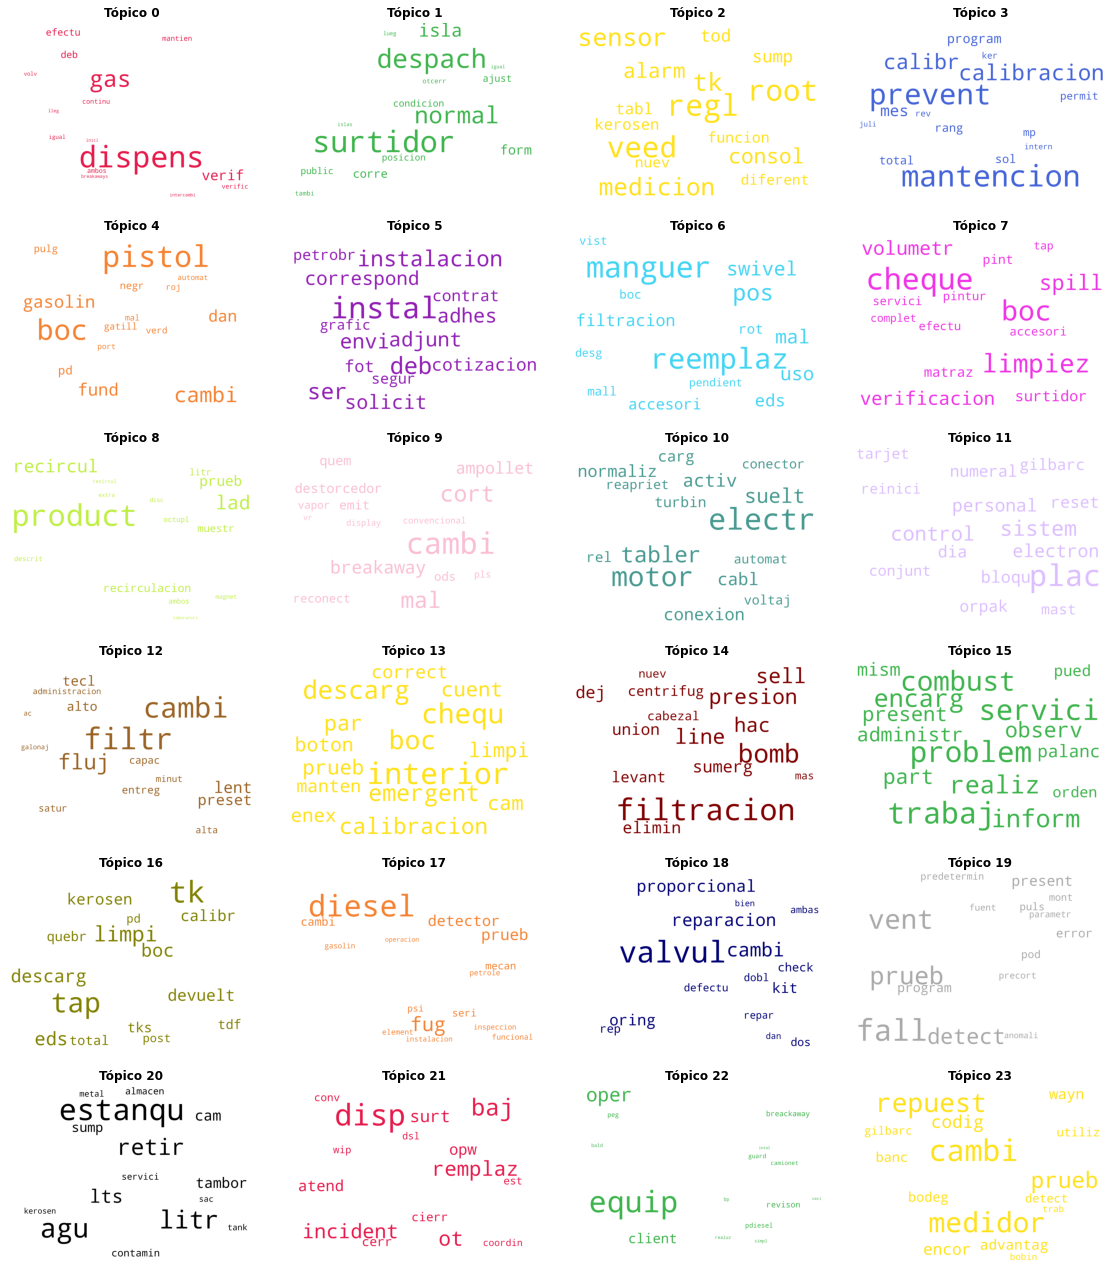

In [50]:
# NUBE DE PALABRAS
word_cloud(lda_model = optimal_model,rows = 6, cols = 4, figsize=(16,18),save = False)

#### Distribución de la frecuencia de palabras

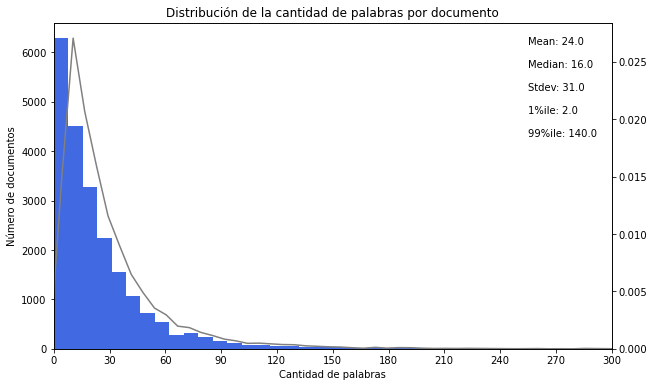

In [52]:
# DISTRIBUCIÓN DE LA FRECUENCIA DE LAS PALABRAS EN LOS DOCUMENTOS 
doc_lens = [len(d) for d in df_dominant_topic.Text]
plot_freqdist(doc_lens, bins = 100, width_text = 0.85, height_text = 0.65,figsize = (10,6), save = False)

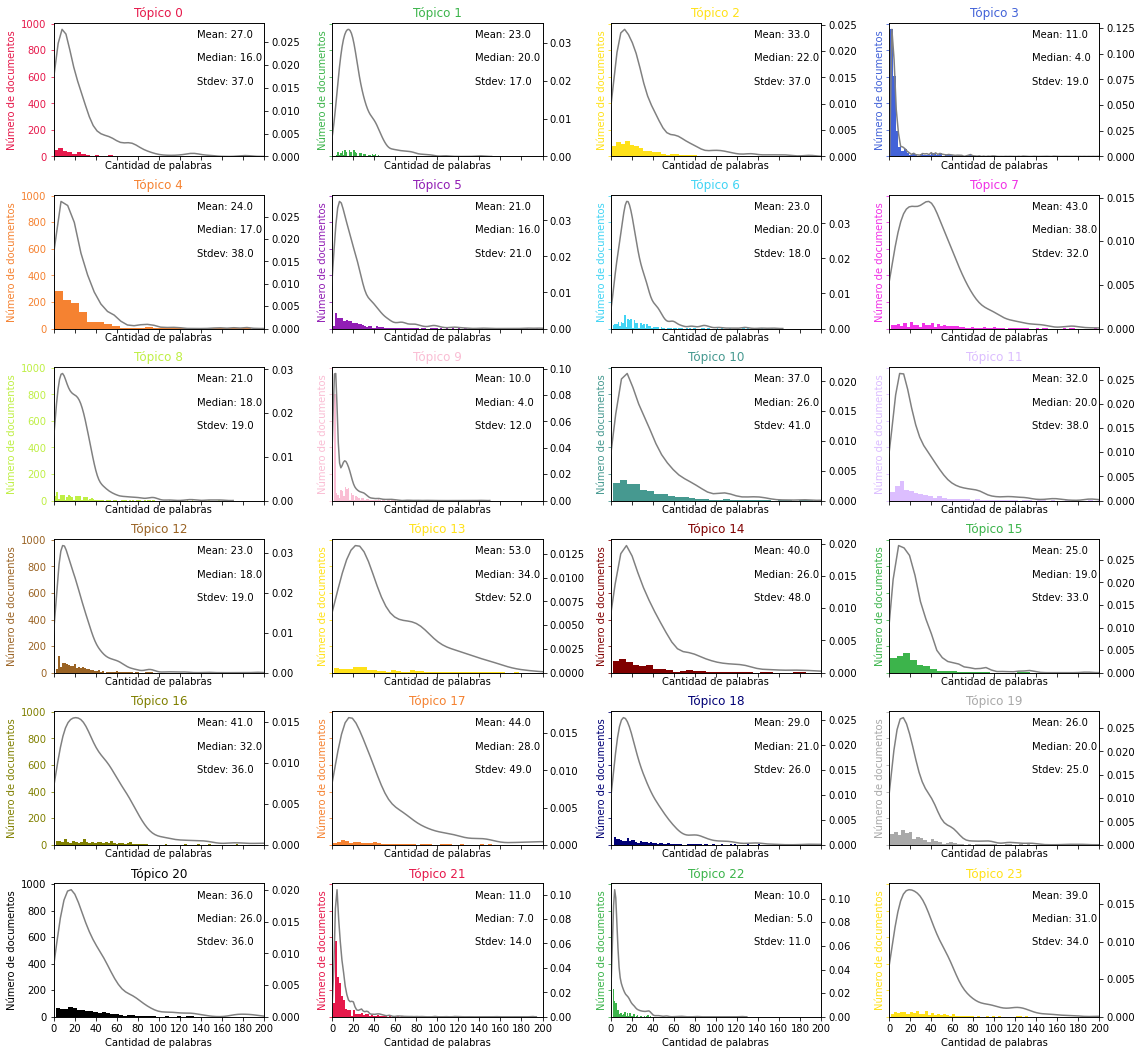

In [53]:
# DISTRIBUCIÓN DE LA FRECUENCIA DE LAS PALABRAS EN LOS TÓPICOS
plot_freqdist_topic(doc_lens,rows = 6, cols = 4, bins = 100,width_text=0.68, height_text= 0.54, figsize = (16,16), save = False)

### EXTRACCIÓN DE INFORMACIÓN 

In [55]:
# TÓPICO DOMINANTE EN DF TOTAL
'''
pd.options.display.max_colwidth = 8
df_topic = pd.read_pickle('../1. OGC - Análisis y limpieza BD/BD_original_reducida_cleaned.pkl')
df_topic['Topico Dominante'] = df_dominant_topic['Dominant_Topic']
df_topic['Topico Dominante'] = df_topic['Topico Dominante'].astype(int)
df_topic.to_pickle('BD_original_cleaned_TOPICO_DOMINANTE_STEMMING.pkl')
df_topic.to_excel('BD_original_cleaned_TOPICO_DOMINANTE_STEMMING.xlsx')
df_topic.head()
'''

"\npd.options.display.max_colwidth = 8\ndf_topic = pd.read_pickle('../1. OGC - Análisis y limpieza BD/BD_original_reducida_cleaned.pkl')\ndf_topic['Topico Dominante'] = df_dominant_topic['Dominant_Topic']\ndf_topic['Topico Dominante'] = df_topic['Topico Dominante'].astype(int)\ndf_topic.to_pickle('BD_original_cleaned_TOPICO_DOMINANTE_STEMMING.pkl')\ndf_topic.to_excel('BD_original_cleaned_TOPICO_DOMINANTE_STEMMING.xlsx')\ndf_topic.head()\n"

In [56]:
df_topic = pd.read_pickle('BD_original_cleaned_TOPICO_DOMINANTE_STEMMING.pkl')
df_dominant_topic = pd.read_pickle('df_dominant_topic_obs_stem.pkl')
df_topic_distribution = pd.read_pickle('df_topic_distribution_obs_stem.pkl')
sent_topics_sorteddf_mallet = pd.read_pickle('sent_topics_sorteddf_mallet_obs_stem.pkl')
df_topic.head()

,Region,Estacion,Tipo de Falla,Prioridad Cliente,Estado OT,Tecnico Asignado,Dia,Nro Dia,Mes,Hora,Rango Recep/Arribo,Rango Arribo/Cierre,Observación,Requerimiento,Topico Dominante
0,13°,Tingaro Spa.,Carrete RetractilOTROOTRO,Normal 48 Horas,CERRADA,Juan Aliaga,Viernes,30,AGO 19,16,Error en fechas,Más de 1 mes,se cambia placa de tk 2 gas95 por placa que indica que es producto 93 se pintan tapas ...,area de atencion habilitar estanque de combustible nro 2 para almacenar gas 93 solicit...,16
1,8°,Combustibles El Volcan Ltda.,Carrete RetractilOTROOTRO,Normal (48 hrs),CERRADA,On Line,Viernes,30,AGO 19,12,Error en fechas,Menos de 1h,cambio de graficas de equipos no esta contemplado en estaciones delegadas,area de atencion combustible maria veronica godoy estimados favor generar incidencia p...,5
2,10°,LLANOS Y WAMMES SOCIEDAD COMERCIAL LTDA.,Carrete RetractilOTROOTRO,Normal 24 Horas,PRECIERRE,Luis Almonacid,Viernes,30,AGO 19,12,0 a 24 horas,Menos de 1h,se visita eds para chequeo de dispensador el cual diller indica que corta a ratos vent...,area de atencion surtidor de diesel a ratos corta venta o no deja despachar sin reinic...,1
3,1°,Soc. Imp. y Exp. Nuevo Amanecer Ltda. (SOCIEX),Carrete RetractilOTROOTRO,Normal (48 hrs),CERRADA,On Line,Viernes,30,AGO 19,12,0 a 24 horas,Menos de 1h,remplazo de graficas no esta contemplado en estaciones delegadas,area de atencion combustible cambiar graficas de surtidores ya que estan un poco deter...,5
4,3°,Inmobiliaria e Inversiones San José Ltda (Vallenar),Carrete RetractilOTROOTRO,Normal (48 hrs),CERRADA,On Line,Viernes,30,AGO 19,12,Error en fechas,Menos de 1h,remplazo de graficas no esta contemplado en contrato para estaciones delegadas,area de atencion combustible solicita grafica para surtidores norma rivera,5


In [57]:
df_topic.shape

(21840, 15)

#### Distribución de OT por tópico

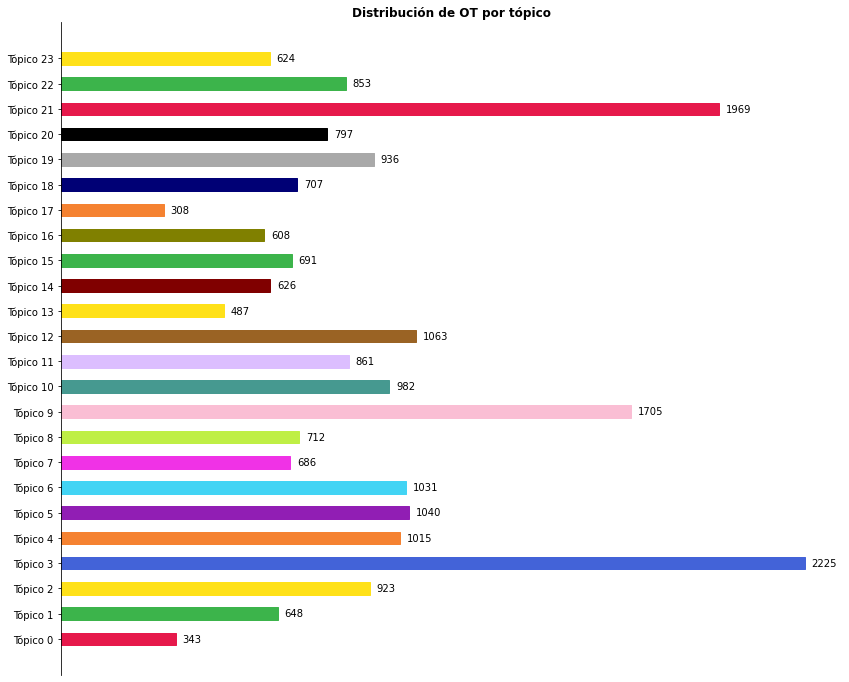

In [59]:
# DISTRIBUCIÓN DE OT POR TÓPICO
topic_distribution(name=None,namecol=None, df_topic=df_topic, vplus = 20,fontsize=12, figsize=(14,12), save = False)

#### Selección y análisis de un tópico K 

In [60]:
# TEXTO REPRESENTATIVO
keywords_text(topic_nro=10, df = sent_topics_sorteddf_mallet)

Top 10 palabras en Tópico 10
['electr, motor, tabler, suelt, activ, cabl, conexion, normaliz, carg, turbin']

Texto representativo en Tópico 10
[['par', 'emergent', 'instal', 'lej', 'surtidor', 'regulariz', 'letrer', 'visibl', 'luminari', 'marquesin', 'luc', 'quem', 'sol', 'encend', 'dia', 'noch', 'cambi', 'luminari', 'instalacion', 'temporiz', 'program', 'encend', 'apag', 'luminari', 'cambi', 'guardamotor', 'normaliz', 'motor', 'surtidor', 'conect', 'sol', 'guardamotor', 'luz', 'pilot', 'quem', 'normaliz', 'rotulacion', 'component', 'tap', 'tabler', 'electr', 'contratap', 'segur', 'cierr', 'puert', 'cerradur', 'puert', 'principal', 'caset', 'defectu', 'plan', 'unilineal', 'mantencion', 'prevent', 'inspeccion', 'tabler', 'electr', 'servici', 'modul', 'sulfur', 'limpiez', 'interior', 'exterior', 'apriet', 'born', 'protector', 'luc', 'pilot', 'par', 'emergent', 'medicion', 'voltaj', 'amperaj', 'tap', 'contratap', 'puert', 'automat', 'proteccion', 'diferencial', 'verificacion', 'plan', 'u

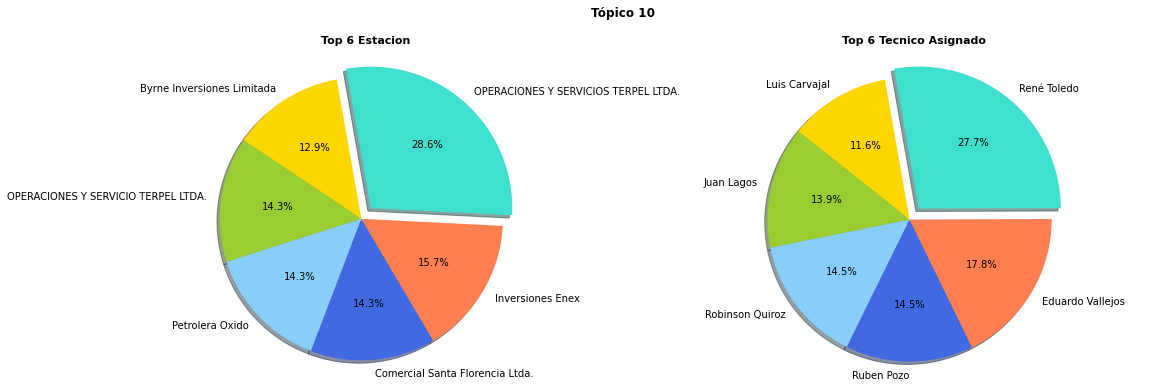

In [61]:
# Distribución de top 6 estaciones y top 6 técnicos en tópico anterior
topic_col1_col2(topic_nro=10, namecol1='Estacion', namecol2='Tecnico Asignado', df=df_topic, figsize = (18,6), save = True)

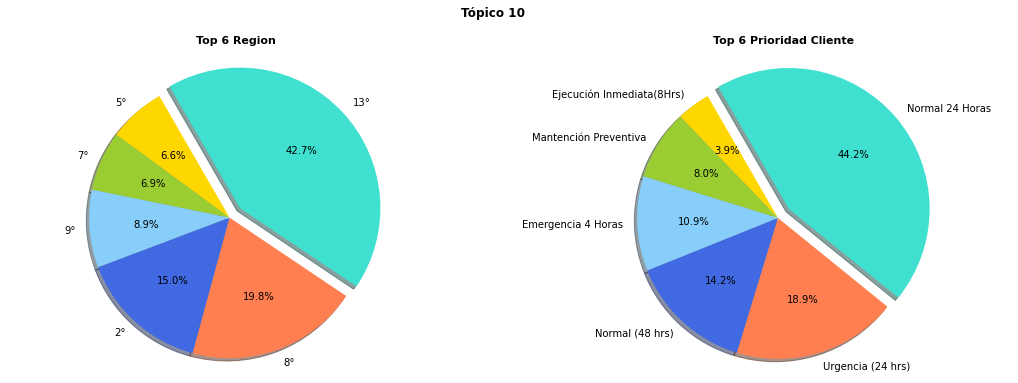

In [62]:
# Distribución de top 6 regiones y top 6 prioridad cliente en tópico anterior
topic_col1_col2(topic_nro=10, namecol1='Region', namecol2='Prioridad Cliente', df=df_topic, figsize = (18,6), save = True, angle = 120)

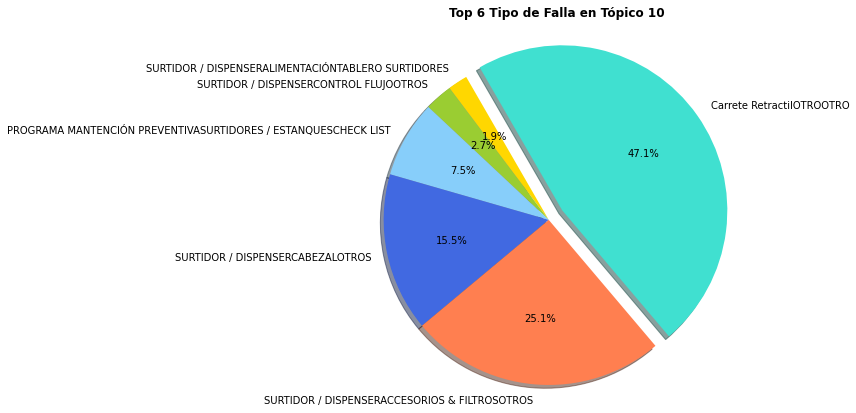

In [63]:
topic_namecol1(topic_nro=10, namecol = 'Tipo de Falla', df=df_topic, angle=120,figsize = (10,7), save = True)

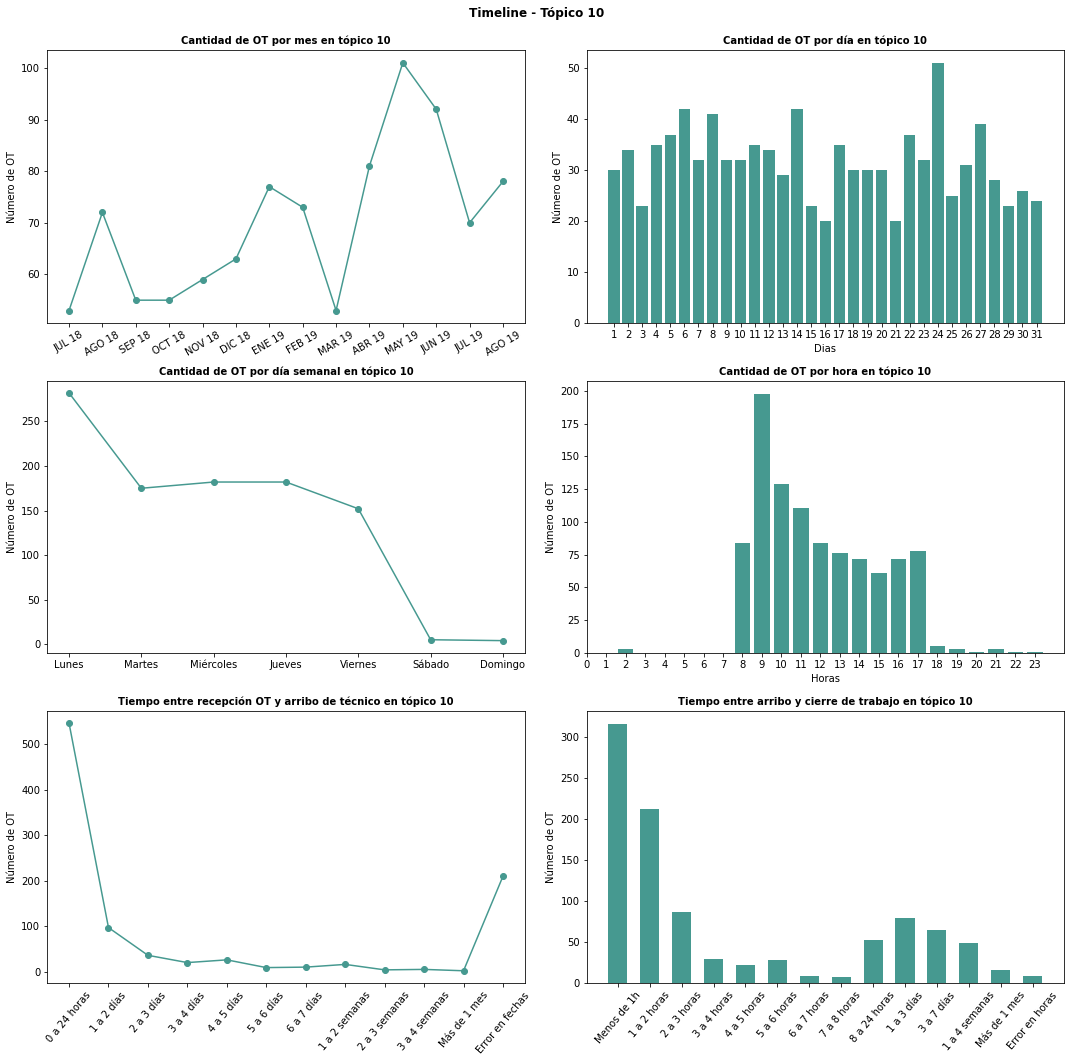

In [66]:
# Evolución de topico anterior con el paso del tiempo (meses, dias nro y horas)                                                              
topic_timeline(name=None, namecol = None, topic_nro=10, df_topic = df_topic, figsize=[15,15], save = False)

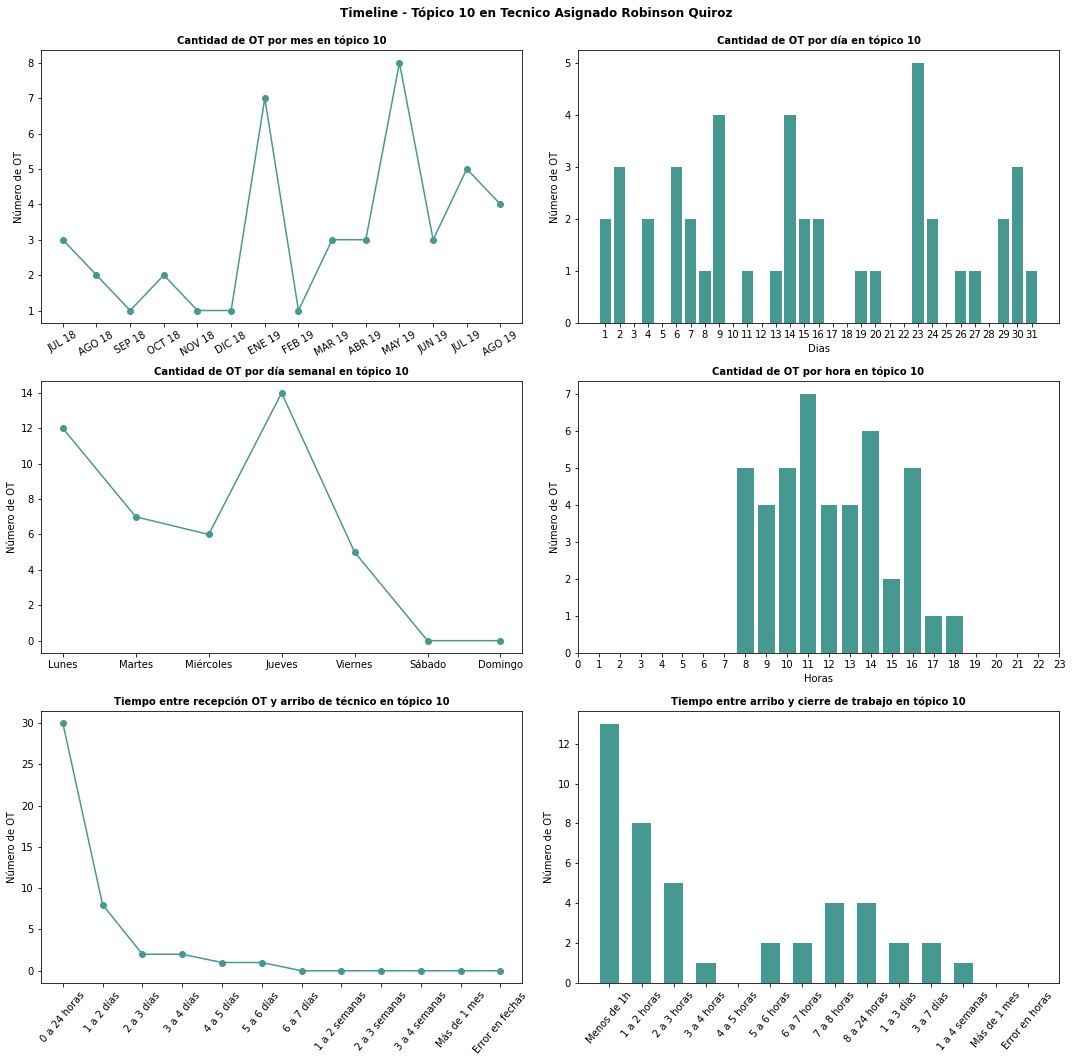

In [67]:
# Mismo tópico, pero ahora timeline exclusiva en un atributo (ROBINSON QUIROZ - TECNICO)                                                           
topic_timeline(name='Robinson Quiroz', namecol = 'Tecnico Asignado', topic_nro=10, df_topic = df_topic, figsize=[15,15], save = False)

#### Tópicos en estaciones top 10

Número de estaciones: 999


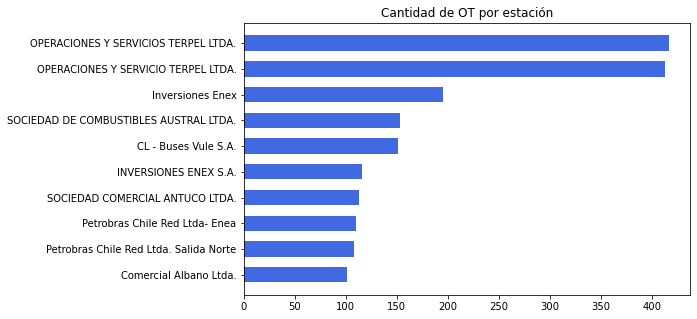

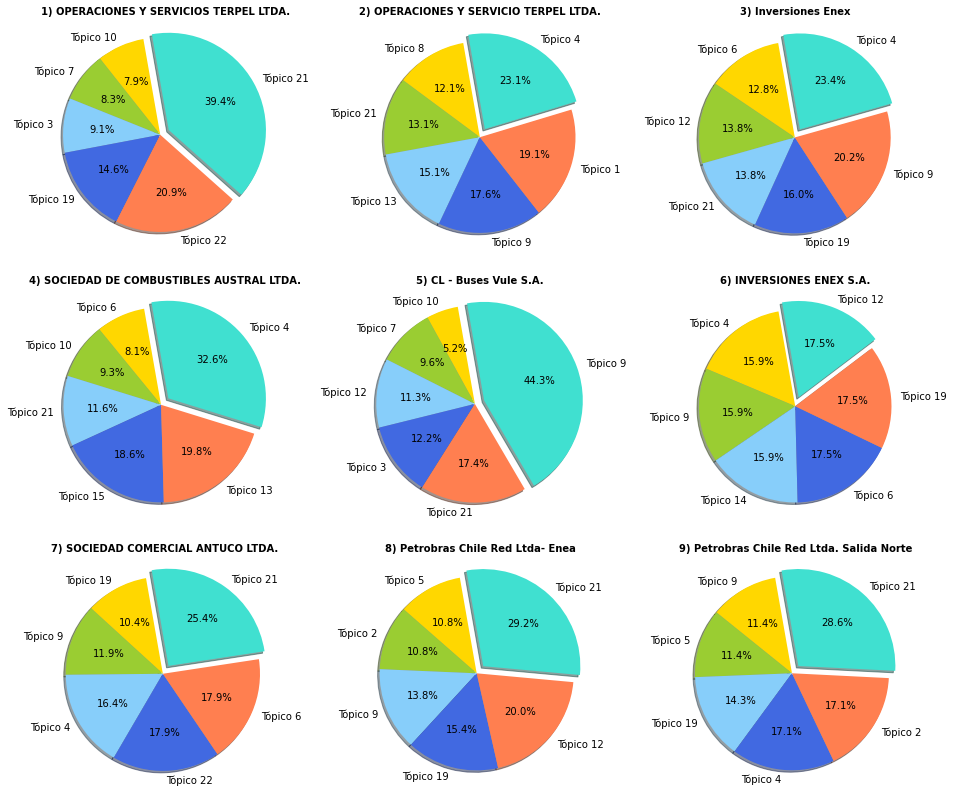

In [68]:
# PORCENTAJE DE TÓPICOS EN TOP 10 ESTACIONES CON MÁS OT
df = df_topic.copy()
print((f"\033[1mNúmero de estaciones: {len(sorted(df['Estacion'].unique()))}\033[0m"))
estacion_total= Counter(df["Estacion"])
dic_est_total = estacion_total.most_common(10)
keys_est_total = [i for i,v in dic_est_total][::-1]
values_est_total = [v for i,v in dic_est_total][::-1]
plt.rcParams.update({'figure.figsize':(8,5)})
plt.barh(keys_est_total,values_est_total, align = 'center', color = 'royalblue', height=0.6)
plt.title("Cantidad de OT por estación")
plt.show()
print('\n')
topics_top9(namecol='Estacion', df=df_topic, figsize = (16,14))

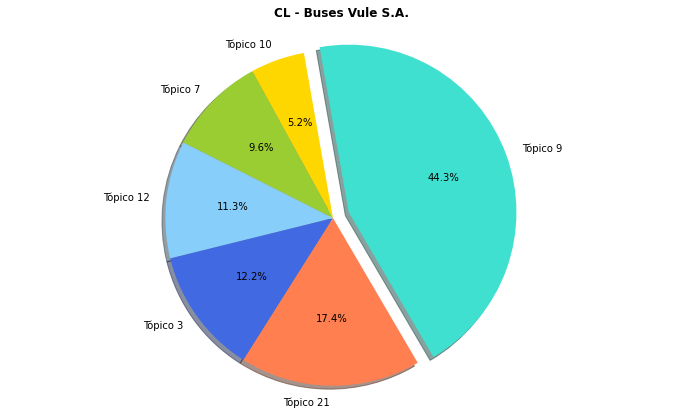

In [69]:
# PORCENTAJE DE TOPICOS EN UN SOLO ITEM
topics_top1(name= 'CL - Buses Vule S.A.', namecol= 'Estacion', df = df_topic, figsize=(12,7))

In [70]:
# TEXTO REPRESENTATIVO
keywords_text(topic_nro=9, df = sent_topics_sorteddf_mallet)

Top 10 palabras en Tópico 9
['cambi, cort, mal, breakaway, ampollet, destorcedor, quem, emit, ods, reconect']

Texto representativo en Tópico 9
[['cambi', 'manguer', 'vapor', 'breakaway', 'vapor', 'recovery', 'wip', 'hos', 'vapor', 'recovery', 'dispens', 'multi', 'product', 'estis', 'encontr', 'defectu', 'permit', 'correct', 'cambi', 'breakaway', 'vapor', 'recovery', 'dispens', 'multi', 'product', 'parti', 'marc', 'cambi', 'manguer', 'vapor', 'breakaway', 'vapor', 'recovery', 'wip', 'hos', 'vapor', 'recovery', 'dispens', 'multi', 'product', 'estis', 'encontr', 'defectu', 'permit', 'correct', 'cambi', 'breakaway', 'vapor', 'recovery', 'dispens', 'multi', 'product', 'parti', 'marc']]


#### Tópicos en OT pendientes

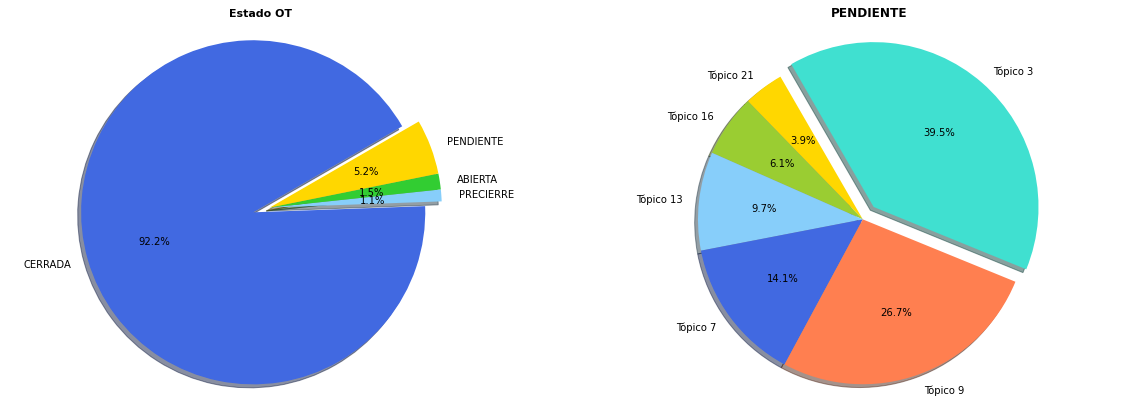

In [71]:
# ESTADO OT - PENDIENTES

plt.figure(1, figsize=(20,7))
plt.subplot(1,2,1)
estadoot_total = Counter(df_topic["Estado OT"])
colors3 = ['royalblue' ,'lightskyblue', 'limegreen', 'gold']
explode = (0.1, 0.0, 0, 0)  # explode 1st slice
keys_ottotal = [i for i in estadoot_total.keys()]
values_ottotal = [i for i in estadoot_total.values()]

plt.pie(values_ottotal,explode=explode, labels=keys_ottotal, colors = colors3,autopct='%1.1f%%', shadow=True, startangle=30)
plt.axis('equal')
plt.title("Estado OT", fontweight="bold", fontdict={'fontsize':11})

plt.subplot(1,2,2)
topics_top1(name= 'PENDIENTE', namecol= 'Estado OT', df = df_topic, angle = 120,figsize=(12,7) )

In [72]:
# Viendo el tópico 3 contienen más pendientes
keywords_text(topic_nro=3, df = sent_topics_sorteddf_mallet)

Top 10 palabras en Tópico 3
['mantencion, prevent, calibracion, calibr, mes, program, rang, sol, total, permit']

Texto representativo en Tópico 3
[['program', 'mantencion', 'prevent', 'mes', 'juli', 'sol', 'calibracion', 'mantencion', 'prevent', 'efectu', 'trabaj', 'calibracion', 'cheque', 'surtidor', 'calibracion', 'matraz', 'litr', 'total', 'dispens', 'normal', 'conform', 'norm', 'permit', 'program', 'mantencion', 'prevent', 'mes', 'juli', 'sol', 'calibracion', 'mantencion', 'prevent', 'efectu', 'trabaj', 'calibracion', 'cheque', 'surtidor', 'calibracion', 'matraz', 'litr', 'total', 'dispens', 'normal', 'conform', 'norm', 'permit']]


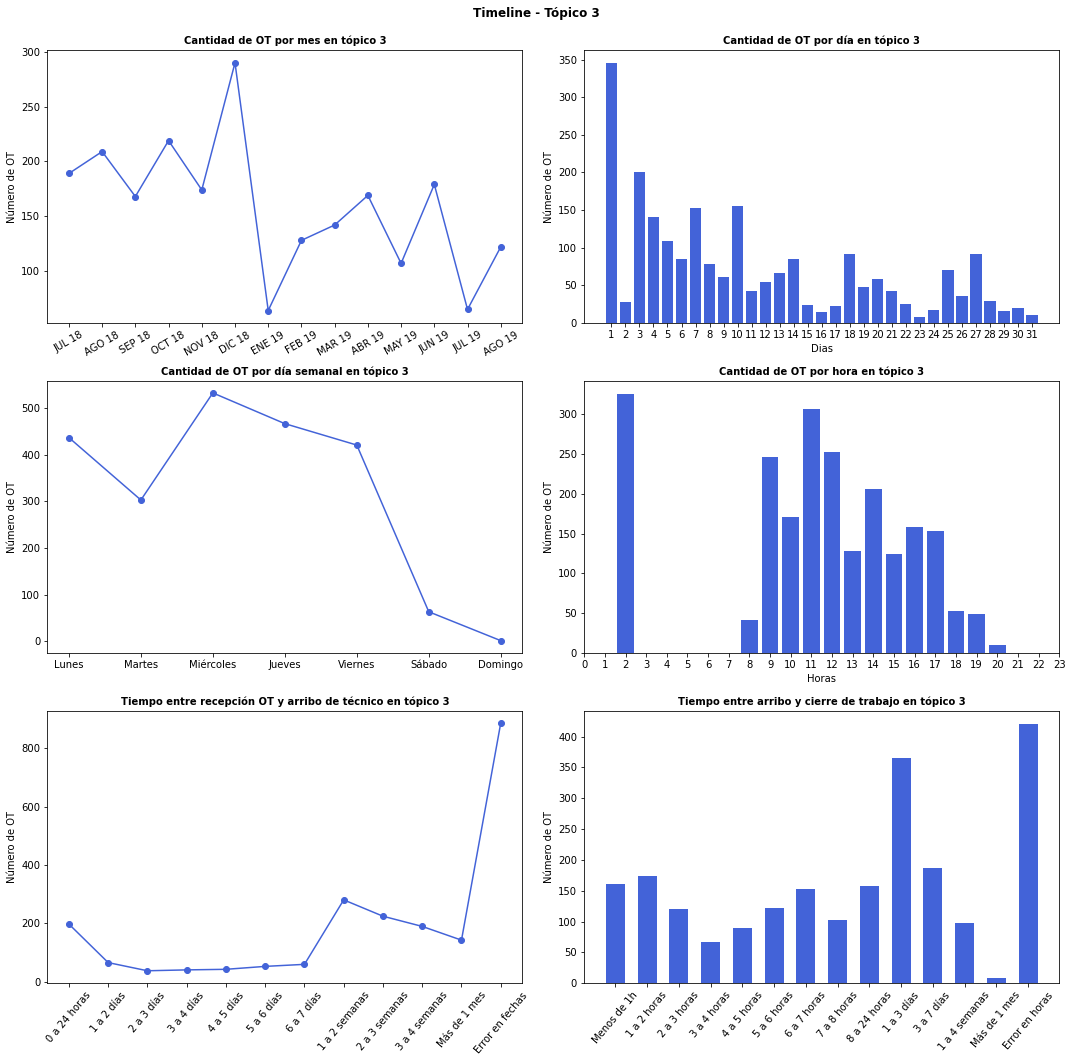

In [74]:
# Analizando todo el tópico 3 en el tiempo debido a las OT pendientes                                                            
topic_timeline(name=None, namecol = None, topic_nro=3, df_topic = df_topic, figsize=(15,15), save = False)

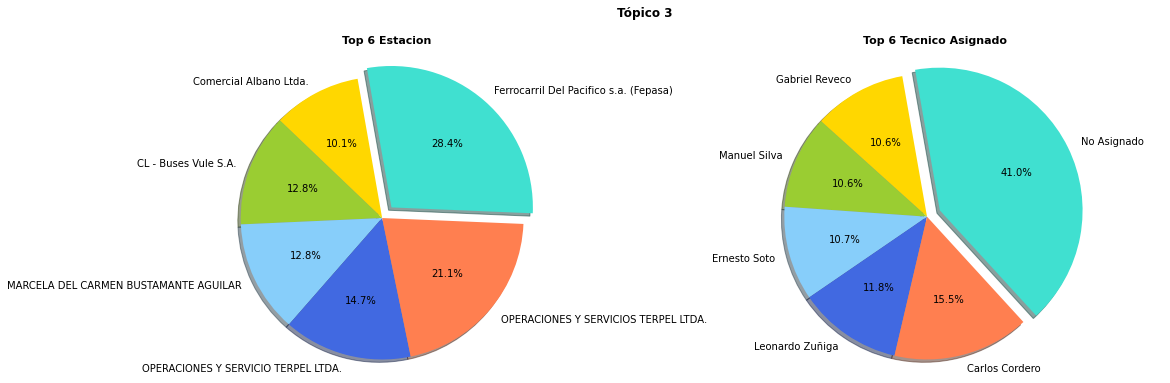

In [75]:
# TOPICO 3 
topic_col1_col2(topic_nro=3, namecol1='Estacion', namecol2='Tecnico Asignado', df=df_topic, figsize = (18,6), save = False)

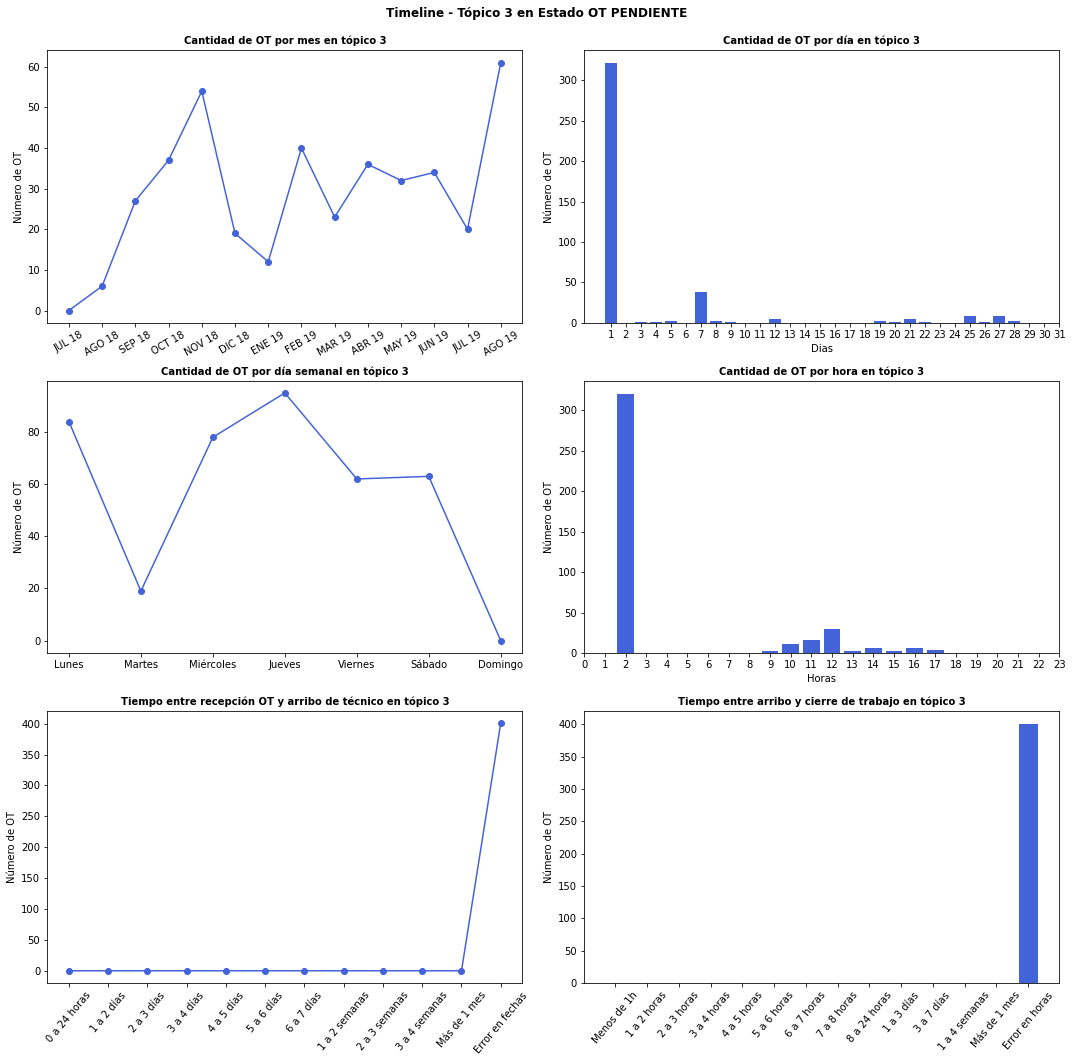

In [77]:
# Tópico 3 exclusivo en OT pendientes                                                             
topic_timeline(name='PENDIENTE', namecol = 'Estado OT', topic_nro=3, df_topic = df_topic, figsize=(15,15), save = False)

#### Tópicos en regiones 

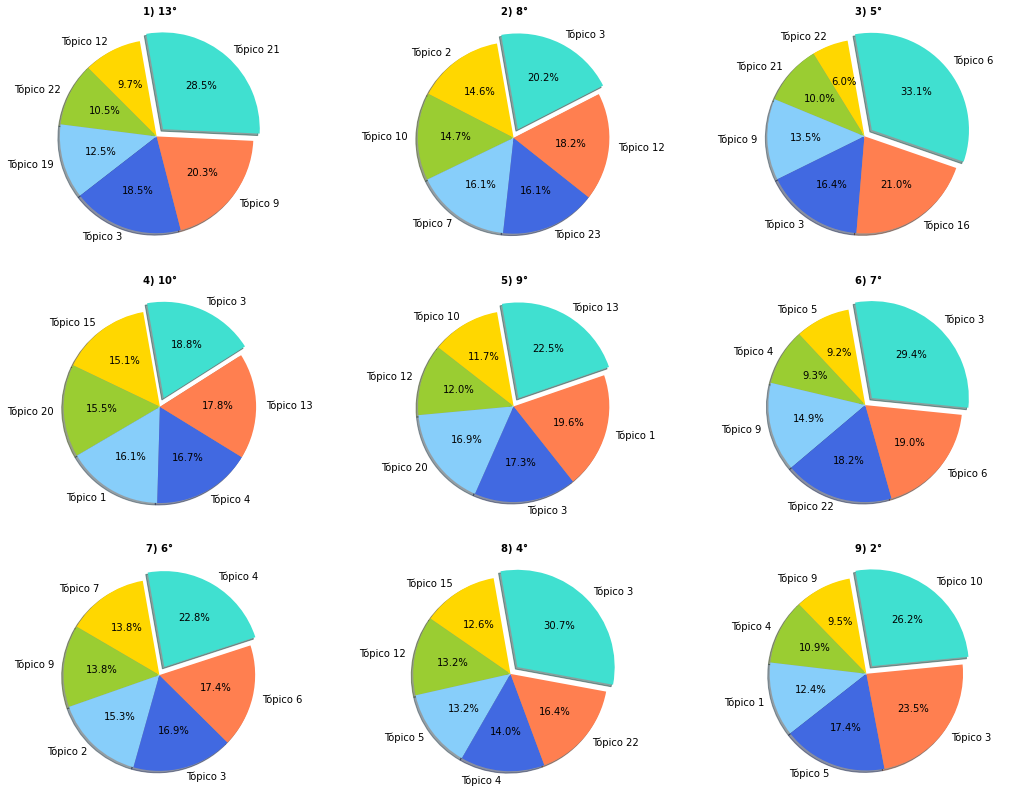

In [78]:
# REGIONES
topics_top9(namecol='Region',df=df_topic)

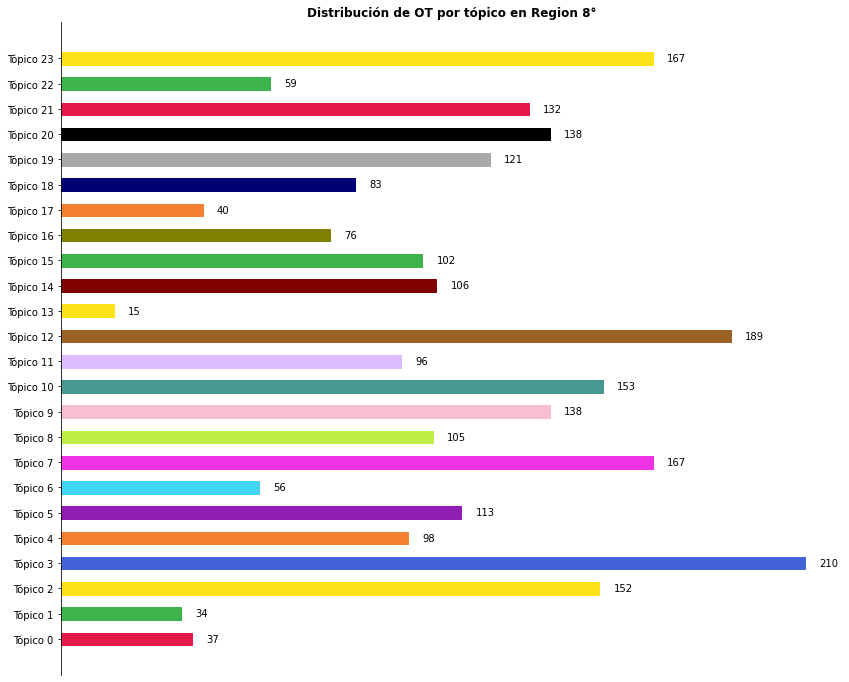

In [91]:
# EN REGION DEL BIO-BIO (8°)
topic_distribution(name= '8°', namecol='Region', df_topic= df_topic, vplus=4,figsize=(14,12), fontsize = 12)

#### Tópicos en técnicos asignados

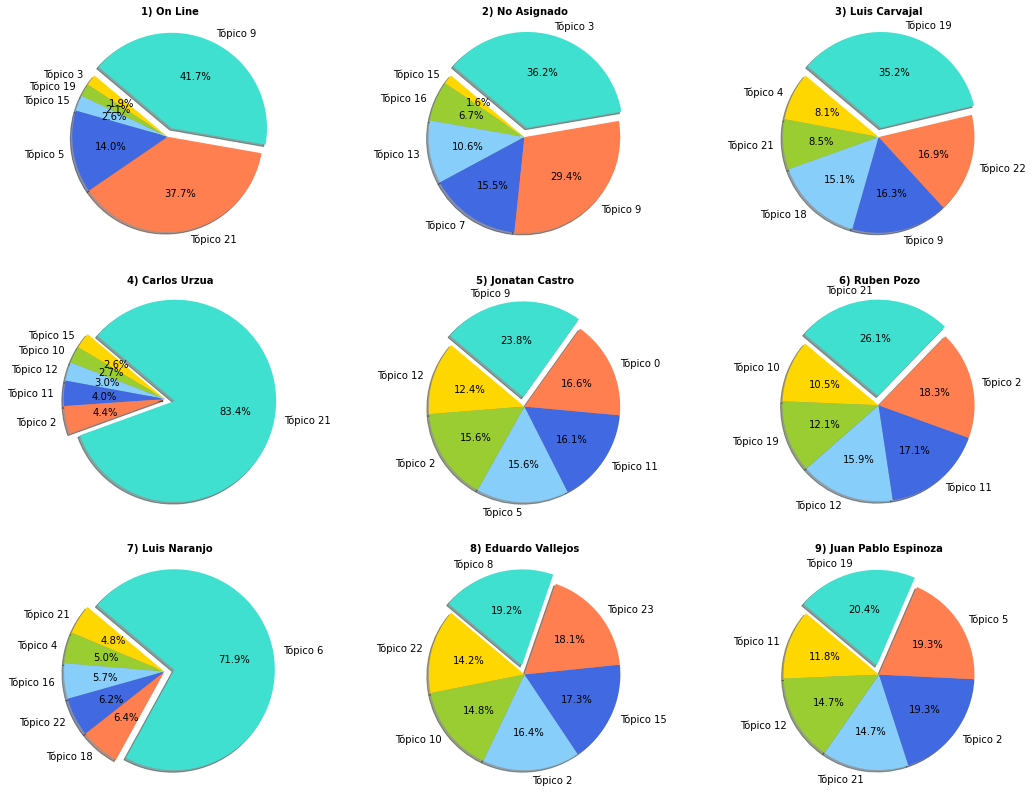

In [80]:
# TECNICOS ASIGNADOS
topics_top9(namecol='Tecnico Asignado',df=df_topic, angle = 140)

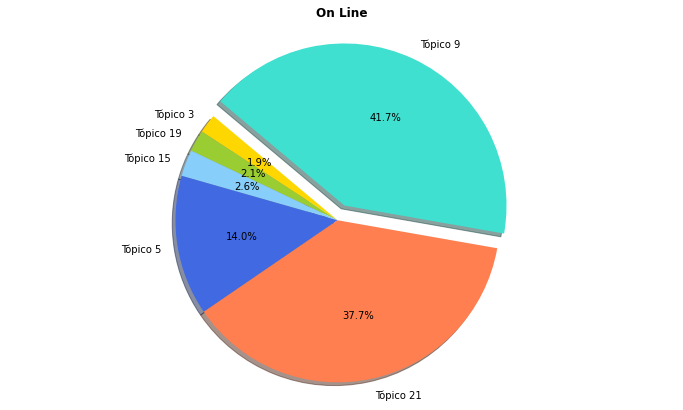

In [81]:
# Seleccionando solo un item para ver de cerca
topics_top1(name= 'On Line', namecol= 'Tecnico Asignado', df = df_topic, angle = 140,figsize=(12,7))

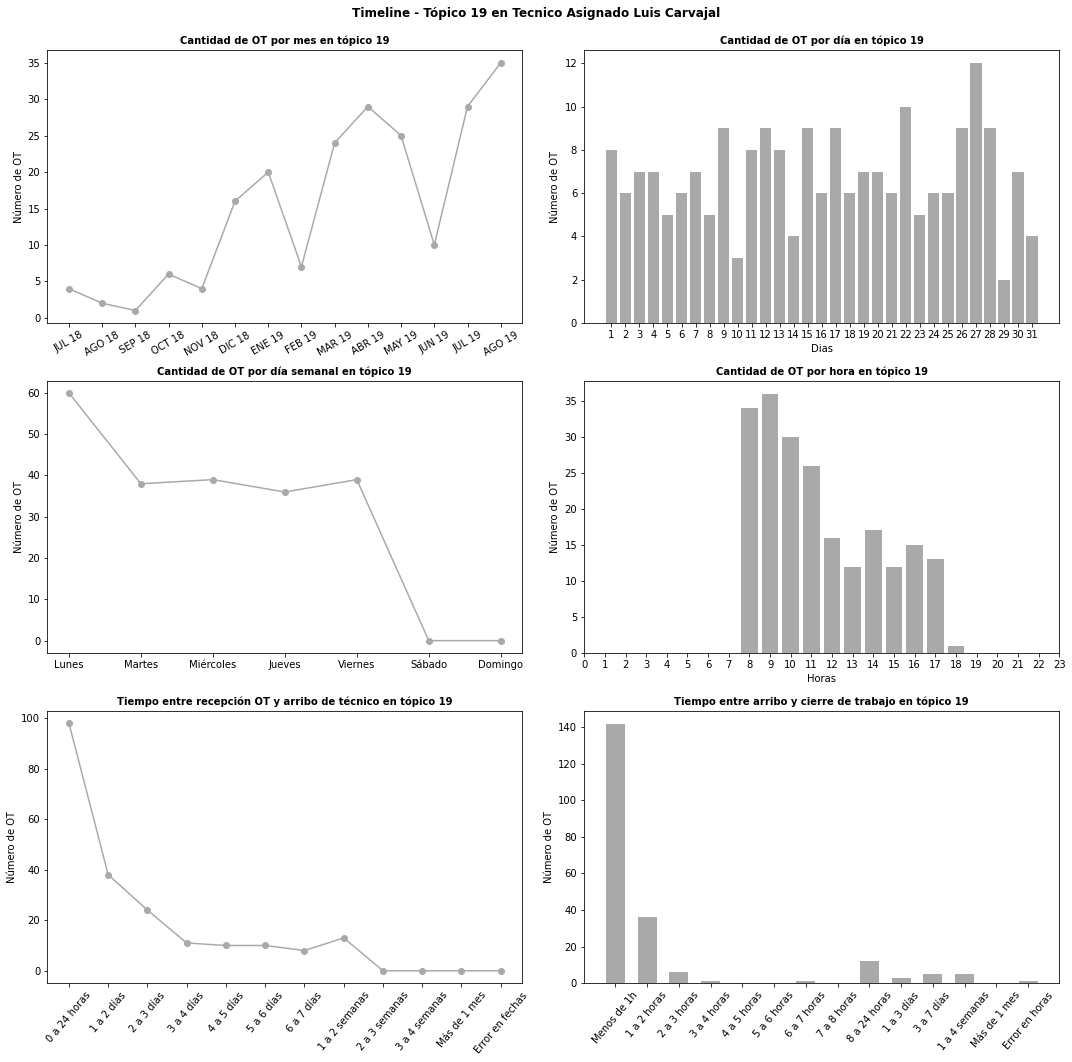

In [88]:
# Seleccionando a Luis Carvajal 
topic_timeline(name='Luis Carvajal', namecol = 'Tecnico Asignado', topic_nro=19, df_topic = df_topic, figsize=(15,15), save = False)

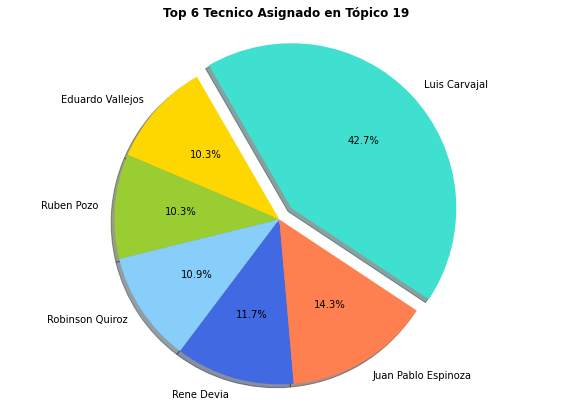

In [89]:
# Será Luis Carvajal el técnico con más OT en tópico 19 ? 
topic_namecol1(topic_nro=19, namecol = 'Tecnico Asignado', df=df_topic, angle=120,figsize = (10,7), save = False)